# **Homework 5 - Sequence-to-sequence**

若有任何問題，歡迎來信至助教信箱 ntu-ml-2021spring-ta@googlegroups.com

### (4/21 Updates)
1. Link to reference [training curves](https://wandb.ai/george0828zhang/hw5.seq2seq.new).

### (4/14 Updates) 
1. Link to tutorial [video](https://youtu.be/htG5WpZVQPU).
2. Now defaults to load `"avg_last_5_checkpoint.pt"` to generate prediction.
3. Expected run time on Colab with Tesla T4

|Baseline|Details|Total Time|
|-|:-:|:-:|
|Simple|2m 15s $\times$30 epochs|1hr 8m|
|Medium|4m $\times$30 epochs|2hr|
|Strong|8m $\times$30 epochs (backward)<br>+1hr (back-translation)<br>+15m $\times$30 epochs (forward)|12hr 30m|

# Sequence-to-Sequence 介紹
- 大多數常見的 seq2seq model 為 encoder-decoder model，主要由兩個部分組成，分別是 encoder 和 decoder，而這兩個部可以使用 recurrent neural network (RNN)或 transformer 來實作，主要是用來解決輸入和輸出的長度不一樣的情況
- **Encoder** 是將一連串的輸入，如文字、影片、聲音訊號等，編碼為單個向量，這單個向量可以想像為是整個輸入的抽象表示，包含了整個輸入的資訊
- **Decoder** 是將 encoder 輸出的單個向量逐步解碼，一次輸出一個結果，直到將最後目標輸出被產生出來為止，每次輸出會影響下一次的輸出，一般會在開頭加入 "< BOS >" 來表示開始解碼，會在結尾輸出 "< EOS >" 來表示輸出結束


![seq2seq](https://i.imgur.com/0zeDyuI.png)

# 作業介紹
- 英文翻譯中文
  - 輸入： 一句英文 （e.g.		tom is a student .） 
  - 輸出： 中文翻譯 （e.g. 		湯姆 是 個 學生 。）

- TODO
  - 訓練一個 RNN 模型達到 Seq2seq 翻譯
  - 訓練一個 Transformer 大幅提升效能
  - 實作 Back-translation 大幅提升效能

# 下載和引入需要的函式庫

In [1]:
!pip3 install 'torch>=1.6.0' editdistance matplotlib sacrebleu sacremoses sentencepiece tqdm wandb
!pip3 install --upgrade jupyter ipywidgets

Requirement already up-to-date: jupyter in /home/bill/.local/lib/python3.8/site-packages (1.0.0)
Requirement already up-to-date: ipywidgets in /home/bill/.local/lib/python3.8/site-packages (7.6.3)


In [2]:
!git clone https://github.com/pytorch/fairseq.git
!cd fairseq && git checkout 9a1c497
!pip3 install --upgrade ./fairseq/

fatal: destination path 'fairseq' already exists and is not an empty directory.
HEAD is now at 9a1c4970 Make Hydra logging work with DDP (#1568)
Processing ./fairseq
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for fairseq: filename=fairseq-1.0.0a0+9a1c497-cp38-cp38-linux_x86_64.whl size=2120953 sha256=3939fe33922069a2243b051b1b9c3da7a76d801436296cfe84d2db2b24cbb898
  Stored in directory: /tmp/pip-ephem-wheel-cache-v26a8j1f/wheels/21/d8/8f/e803e4e59232f7570ad689490b5a241021ce2800706905d1e5
Successfully built fairseq
  Attempting uninstall: fairseq
    Found existing installation: fairseq 1.0.0a0+9a1c497
    Uninstalling fairseq-1.0.0a0+9a1c497:
      Successfully uninstalled fairseq-1.0.0a0+9a1c497


In [3]:
import sys
import pdb
import pprint
import logging
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import numpy as np
from tqdm import tqdm
from pathlib import Path
from argparse import Namespace
from fairseq import utils

import matplotlib.pyplot as plt

# 設定種子

In [4]:
seed = 73
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
np.random.seed(seed)  
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# 資料集介紹

## 英轉繁雙語資料
* [TED2020](#reimers-2020-multilingual-sentence-bert)
    - 原始資料量: 398,066句    
    - 處理後資料: 393,980句
    

## 測試資料
- 資料量: 4,000句
- **中文部分不公開，提供的檔案為假翻譯，全部都是句點。**

# 資料下載

### 安裝megatools (optional)

In [5]:
#!apt-get install megatools

## 下載檔案並解壓縮

In [6]:
data_dir = './DATA/rawdata'
dataset_name = 'ted2020'
urls = (
    '"https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214989&authkey=AGgQ-DaR8eFSl1A"', 
    '"https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214987&authkey=AA4qP_azsicwZZM"',
# # If the above links die, use the following instead. 
#     "https://www.csie.ntu.edu.tw/~r09922057/ML2021-hw5/ted2020.tgz",
#     "https://www.csie.ntu.edu.tw/~r09922057/ML2021-hw5/test.tgz",
# # If the above links die, use the following instead. 
#     "https://mega.nz/#!vEcTCISJ!3Rw0eHTZWPpdHBTbQEqBDikDEdFPr7fI8WxaXK9yZ9U",
#     "https://mega.nz/#!zNcnGIoJ!oPJX9AvVVs11jc0SaK6vxP_lFUNTkEcK2WbxJpvjU5Y",
)
file_names = (
    'ted2020.tgz', # train & dev
    'test.tgz', # test
)
prefix = Path(data_dir).absolute() / dataset_name

prefix.mkdir(parents=True, exist_ok=True)
for u, f in zip(urls, file_names):
    path = prefix/f
    if not path.exists():
        if 'mega' in u:
            !megadl {u} --path {path}
        else:
            !wget {u} -O {path}
    if path.suffix == ".tgz":
        !tar -xvf {path} -C {prefix}
    elif path.suffix == ".zip":
        !unzip -o {path} -d {prefix}
!mv {prefix/'raw.en'} {prefix/'train_dev.raw.en'}
!mv {prefix/'raw.zh'} {prefix/'train_dev.raw.zh'}
!mv {prefix/'test.en'} {prefix/'test.raw.en'}
!mv {prefix/'test.zh'} {prefix/'test.raw.zh'}

raw.en
raw.zh
test.en
test.zh


## 設定語言

In [7]:
src_lang = 'zh'
tgt_lang = 'en'

data_prefix = f'{prefix}/train_dev.raw'
test_prefix = f'{prefix}/test.raw'

In [8]:
!head {data_prefix+'.'+src_lang} -n 5
!head {data_prefix+'.'+tgt_lang} -n 5

非常謝謝你，克里斯。能有這個機會第二度踏上這個演講台
真是一大榮幸。我非常感激。
這個研討會給我留下了極為深刻的印象，我想感謝大家 對我之前演講的好評。
我是由衷的想這麼說，有部份原因是因為 —— 我真的有需要!
請你們設身處地為我想一想！
Thank you so much, Chris.
And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night.
And I say that sincerely, partly because  I need that.
Put yourselves in my position.


## 檔案前處理

In [9]:
import re

def strQ2B(ustring):
    """把字串全形轉半形"""
    # 參考來源:https://ithelp.ithome.com.tw/articles/10233122
    ss = []
    for s in ustring:
        rstring = ""
        for uchar in s:
            inside_code = ord(uchar)
            if inside_code == 12288:  # 全形空格直接轉換
                inside_code = 32
            elif (inside_code >= 65281 and inside_code <= 65374):  # 全形字元（除空格）根據關係轉化
                inside_code -= 65248
            rstring += chr(inside_code)
        ss.append(rstring)
    return ''.join(ss)
                
def clean_s(s, lang):
    if lang == 'en':
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace('-', '') # remove '-'
        s = re.sub('([.,;!?()\"])', r' \1 ', s) # keep punctuation
    elif lang == 'zh':
        s = strQ2B(s) # Q2B
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace(' ', '')
        s = s.replace('—', '')
        s = s.replace('“', '"')
        s = s.replace('”', '"')
        s = s.replace('_', '')
        s = re.sub('([。,;!?()\"~「」])', r' \1 ', s) # keep punctuation
    s = ' '.join(s.strip().split())
    return s

def len_s(s, lang):
    if lang == 'zh':
        return len(s)
    return len(s.split())

def clean_corpus(prefix, l1, l2, ratio=9, max_len=1000, min_len=1):
    if Path(f'{prefix}.clean.{l1}').exists() and Path(f'{prefix}.clean.{l2}').exists():
        print(f'{prefix}.clean.{l1} & {l2} exists. skipping clean.')
        return
    with open(f'{prefix}.{l1}', 'r') as l1_in_f:
        with open(f'{prefix}.{l2}', 'r') as l2_in_f:
            with open(f'{prefix}.clean.{l1}', 'w') as l1_out_f:
                with open(f'{prefix}.clean.{l2}', 'w') as l2_out_f:
                    for s1 in l1_in_f:
                        s1 = s1.strip()
                        s2 = l2_in_f.readline().strip()
                        s1 = clean_s(s1, l1)
                        s2 = clean_s(s2, l2)
                        s1_len = len_s(s1, l1)
                        s2_len = len_s(s2, l2)
                        if min_len > 0: # remove short sentence
                            if s1_len < min_len or s2_len < min_len:
                                continue
                        if max_len > 0: # remove long sentence
                            if s1_len > max_len or s2_len > max_len:
                                continue
                        if ratio > 0: # remove by ratio of length
                            if s1_len/s2_len > ratio or s2_len/s1_len > ratio:
                                continue
                        print(s1, file=l1_out_f)
                        print(s2, file=l2_out_f)

In [10]:
clean_corpus(data_prefix, src_lang, tgt_lang)
clean_corpus(test_prefix, src_lang, tgt_lang, ratio=-1, min_len=-1, max_len=-1)

/home/bill/Desktop/Graduate_course/ML2021/hw5/DATA/rawdata/ted2020/train_dev.raw.clean.zh & en exists. skipping clean.
/home/bill/Desktop/Graduate_course/ML2021/hw5/DATA/rawdata/ted2020/test.raw.clean.zh & en exists. skipping clean.


In [11]:
!head {data_prefix+'.clean.'+src_lang} -n 5
!head {data_prefix+'.clean.'+tgt_lang} -n 5

非常謝謝你 , 克里斯 。 能有這個機會第二度踏上這個演講台
真是一大榮幸 。 我非常感激 。
這個研討會給我留下了極為深刻的印象 , 我想感謝大家對我之前演講的好評 。
我是由衷的想這麼說 , 有部份原因是因為我真的有需要 !
請你們設身處地為我想一想 !
Thank you so much , Chris .
And it's truly a great honor to have the opportunity to come to this stage twice ; I'm extremely grateful .
I have been blown away by this conference , and I want to thank all of you for the many nice comments about what I had to say the other night .
And I say that sincerely , partly because I need that .
Put yourselves in my position .


## 切出 train/valid set

In [12]:
valid_ratio = 0.01 # 3000~4000句就夠了
train_ratio = 1 - valid_ratio

In [13]:
if (prefix/f'train.clean.{src_lang}').exists() \
and (prefix/f'train.clean.{tgt_lang}').exists() \
and (prefix/f'valid.clean.{src_lang}').exists() \
and (prefix/f'valid.clean.{tgt_lang}').exists():
    print(f'train/valid splits exists. skipping split.')
else:
    line_num = sum(1 for line in open(f'{data_prefix}.clean.{src_lang}'))
    labels = list(range(line_num))
    random.shuffle(labels)
    for lang in [src_lang, tgt_lang]:
        train_f = open(os.path.join(data_dir, dataset_name, f'train.clean.{lang}'), 'w')
        valid_f = open(os.path.join(data_dir, dataset_name, f'valid.clean.{lang}'), 'w')
        count = 0
        for line in open(f'{data_prefix}.clean.{lang}', 'r'):
            if labels[count]/line_num < train_ratio:
                train_f.write(line)
            else:
                valid_f.write(line)
            count += 1
        train_f.close()
        valid_f.close()

train/valid splits exists. skipping split.


## Subword Units 
翻譯存在的一大問題是未登錄詞(out of vocabulary)，可以使用 subword units 作為斷詞單位來解決。
- 使用 [sentencepiece](#kudo-richardson-2018-sentencepiece) 套件
- 用 unigram 或 byte-pair encoding (BPE)

In [14]:
import sentencepiece as spm
vocab_size = 8000
if (prefix/f'spm{vocab_size}.model').exists():
    print(f'{prefix}/spm{vocab_size}.model exists. skipping spm_train.')
else:
    spm.SentencePieceTrainer.train(
        input=','.join([f'{prefix}/train.clean.{src_lang}',
                        f'{prefix}/valid.clean.{src_lang}',
                        f'{prefix}/train.clean.{tgt_lang}',
                        f'{prefix}/valid.clean.{tgt_lang}']),
        model_prefix=prefix/f'spm{vocab_size}',
        vocab_size=vocab_size,
        character_coverage=1,
        model_type='unigram', # 'bpe' 也可
        input_sentence_size=1e6,
        shuffle_input_sentence=True,
        normalization_rule_name='nmt_nfkc_cf',
    )

/home/bill/Desktop/Graduate_course/ML2021/hw5/DATA/rawdata/ted2020/spm8000.model exists. skipping spm_train.


In [15]:
spm_model = spm.SentencePieceProcessor(model_file=str(prefix/f'spm{vocab_size}.model'))
in_tag = {
    'train': 'train.clean',
    'valid': 'valid.clean',
    'test': 'test.raw.clean',
}
for split in ['train', 'valid', 'test']:
    for lang in [src_lang, tgt_lang]:
        out_path = prefix/f'{split}.{lang}'
        if out_path.exists():
            print(f"{out_path} exists. skipping spm_encode.")
        else:
            with open(prefix/f'{split}.{lang}', 'w') as out_f:
                with open(prefix/f'{in_tag[split]}.{lang}', 'r') as in_f:
                    for line in in_f:
                        line = line.strip()
                        tok = spm_model.encode(line, out_type=str)
                        print(' '.join(tok), file=out_f)

/home/bill/Desktop/Graduate_course/ML2021/hw5/DATA/rawdata/ted2020/train.zh exists. skipping spm_encode.
/home/bill/Desktop/Graduate_course/ML2021/hw5/DATA/rawdata/ted2020/train.en exists. skipping spm_encode.
/home/bill/Desktop/Graduate_course/ML2021/hw5/DATA/rawdata/ted2020/valid.zh exists. skipping spm_encode.
/home/bill/Desktop/Graduate_course/ML2021/hw5/DATA/rawdata/ted2020/valid.en exists. skipping spm_encode.


In [16]:
!head {data_dir+'/'+dataset_name+'/train.'+src_lang} -n 5
!head {data_dir+'/'+dataset_name+'/train.'+tgt_lang} -n 5

▁ 非常 謝 謝 你 ▁, ▁ 克 里 斯 ▁ 。 ▁ 能 有 這個 機會 第二 度 踏 上 這個 演講 台
▁ 真 是 一 大 榮 幸 ▁ 。 ▁我 非常 感 激 ▁ 。
▁這個 研 討 會 給我 留 下 了 極 為 深 刻 的 印 象 ▁, ▁我想 感 謝 大家 對 我 之前 演講 的 好 評 ▁ 。
▁我 是由 衷 的 想 這麼 說 ▁, ▁有 部份 原因 是因為 我 真的 有 需要 ▁ !
▁ 請 你們 設 身 處 地 為 我想 一 想 ▁ !
▁thank ▁you ▁so ▁much ▁, ▁chris ▁.
▁and ▁it ' s ▁ t ru ly ▁a ▁great ▁ho n or ▁to ▁have ▁the ▁ op port un ity ▁to ▁come ▁to ▁this ▁st age ▁ t wi ce ▁ ; ▁i ' m ▁ex t re me ly ▁gr ate ful ▁.
▁i ▁have ▁been ▁ bl own ▁away ▁by ▁this ▁con fer ence ▁, ▁and ▁i ▁want ▁to ▁thank ▁all ▁of ▁you ▁for ▁the ▁many ▁ ni ce ▁ com ment s ▁about ▁what ▁i ▁had ▁to ▁say ▁the ▁other ▁night ▁.
▁and ▁i ▁say ▁that ▁since re ly ▁, ▁part ly ▁because ▁i ▁need ▁that ▁.
▁put ▁your s el ve s ▁in ▁my ▁po s ition ▁.


## 用 fairseq 將資料轉為 binary

In [17]:
binpath = Path('./DATA/data-bin', dataset_name)
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python3 -m fairseq_cli.preprocess \
        --source-lang {src_lang}\
        --target-lang {tgt_lang}\
        --trainpref {prefix/'train'}\
        --validpref {prefix/'valid'}\
        --testpref {prefix/'test'}\
        --destdir {binpath}\
        --joined-dictionary\
        --workers 2

DATA/data-bin/ted2020 exists, will not overwrite!


# 實驗的參數設定表

In [18]:
config = Namespace(
    datadir = "./DATA/data-bin/ted2020",
    savedir = "./checkpoints/rnn",
    source_lang = "zh",
    target_lang = "en",
    
    # cpu threads when fetching & processing data.
    num_workers=1,  
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    max_tokens=4096,
    accum_steps=4,
    
    # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=2.,
    lr_warmup=4000,
    
    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0,
    
    # maximum epochs for training
    max_epoch=30,
    start_epoch=1,
    
    # beam size for beam search
    beam=10, 
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2, 
    max_len_b=10,
    # when decoding, post process sentence by removing sentencepiece symbols.
    post_process = "sentencepiece",
    
    # checkpoints
    keep_last_epochs=5,
    resume=None, # if resume from checkpoint name (under config.savedir)
    
    # logging
    use_wandb=False,
)

# Logging
- logging 套件紀錄一般訊息
- wandb 紀錄續練過程 loss, bleu, model weight 等等

In [19]:
logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level="INFO", # "DEBUG" "WARNING" "ERROR"
    stream=sys.stdout,
)
proj = "hw5.seq2seq"
logger = logging.getLogger(proj)
if config.use_wandb:
    import wandb
    wandb.init(project=proj, name=Path(config.savedir).stem, config=config)

# CUDA環境

In [20]:
cuda_env = utils.CudaEnvironment()
utils.CudaEnvironment.pretty_print_cuda_env_list([cuda_env])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

2021-04-29 15:44:36 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************
2021-04-29 15:44:36 | INFO | fairseq.utils | rank   0: capabilities =  7.5  ; total memory = 10.758 GB ; name = GeForce RTX 2080 Ti                     
2021-04-29 15:44:36 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************


# 讀取資料集

## 借用 fairseq 的 TranslationTask
* 用來讀進上面 binarized 的檔案
* 有現成的 data iterator (dataloader)
* 字典 task.source_dictionary 和 task.target_dictionary 也很好用 
* 有實做 beam search

In [21]:
from fairseq.tasks.translation import TranslationConfig, TranslationTask

## setup task
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2021-04-29 15:44:36 | INFO | fairseq.tasks.translation | [zh] dictionary: 8000 types
2021-04-29 15:44:36 | INFO | fairseq.tasks.translation | [en] dictionary: 8000 types


In [22]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2021-04-29 15:44:36 | INFO | hw5.seq2seq | loading data for epoch 1
2021-04-29 15:44:36 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020/train.zh-en.zh
2021-04-29 15:44:36 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020/train.zh-en.en
2021-04-29 15:44:36 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 train zh-en 390041 examples
2021-04-29 15:44:36 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020/valid.zh-en.zh
2021-04-29 15:44:36 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020/valid.zh-en.en
2021-04-29 15:44:36 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 valid zh-en 3939 examples


In [23]:
sample = task.dataset("valid")[1]
pprint.pprint(sample)
pprint.pprint(
    "Source: " + \
    task.source_dictionary.string(
        sample['source'],
        config.post_process,
    )
)
pprint.pprint(
    "Target: " + \
    task.target_dictionary.string(
        sample['target'],
        config.post_process,
    )
)

{'id': 1,
 'source': tensor([ 145,  684,   30,  270,   40,  168, 1134,  650,  591,  367, 3117, 2417,
        1420,  194,    2]),
 'target': tensor([  18,   14,    6, 2218,   60,   19,   75,    4,  253,   16,  334, 1392,
        1689,    7,    2])}
'Source: 這實在就是我所做的--光學操控思想'
"Target: that's exactly what i do optical mind control ."


## Dataset Iterator

* 將每個 batch 控制在 N 個 token 讓 GPU 記憶體更有效被利用
* 讓 training set 每個 epoch 有不同 shuffling
* 濾掉長度太長的句子
* 將每個 batch 內的句子 pad 成一樣長，好讓 GPU 平行運算
* 加上 eos 並 shift 一格
    - teacher forcing: 為了訓練模型根據prefix生成下個字，decoder的輸入會是輸出目標序列往右shift一格。
    - 一般是會在輸入開頭加個bos token (如下圖)
![seq2seq](https://i.imgur.com/0zeDyuI.png)
    - fairseq 則是直接把 eos 挪到 beginning，訓練起來效果其實差不多。例如: 
    ```
    # 輸出目標 (target) 和 Decoder輸入 (prev_output_tokens): 
                   eos = 2
                target = 419,  711,  238,  888,  792,   60,  968,    8,    2
    prev_output_tokens = 2,  419,  711,  238,  888,  792,   60,  968,    8
    ```


In [24]:
def load_data_iterator(task, split, epoch=1, max_tokens=4000, num_workers=1, cached=True):
    batch_iterator = task.get_batch_iterator(
        dataset=task.dataset(split),
        max_tokens=max_tokens,
        max_sentences=None,
        max_positions=utils.resolve_max_positions(
            task.max_positions(),
            max_tokens,
        ),
        ignore_invalid_inputs=True,
        seed=seed,
        num_workers=num_workers,
        epoch=epoch,
        disable_iterator_cache=not cached,
        # Set this to False to speed up. However, if set to False, changing max_tokens beyond 
        # first call of this method has no effect. 
    )
    return batch_iterator

demo_epoch_obj = load_data_iterator(task, "valid", epoch=1, max_tokens=20, num_workers=1, cached=False)
demo_iter = demo_epoch_obj.next_epoch_itr(shuffle=True)
sample = next(demo_iter)
sample

2021-04-29 15:44:36 | WARNING | fairseq.tasks.fairseq_task | 2,586 samples have invalid sizes and will be skipped, max_positions=(20, 20), first few sample ids=[3525, 1062, 527, 2861, 2415, 1633, 1624, 2626, 210, 880]


{'id': tensor([3517]),
 'nsentences': 1,
 'ntokens': 17,
 'net_input': {'src_tokens': tensor([[   1,    1,    1,    4, 1259, 2926,  157, 3552, 1591,  137,  162, 1173,
            434,    4,   33,    2]]),
  'src_lengths': tensor([13]),
  'prev_output_tokens': tensor([[   2,    4,   32,   63,    8,  796, 1556, 1562,   13,  691,  116,  124,
            188,    4,   33,    4,   32,    1,    1,    1,    1,    1,    1,    1]])},
 'target': tensor([[   4,   32,   63,    8,  796, 1556, 1562,   13,  691,  116,  124,  188,
             4,   33,    4,   32,    2,    1,    1,    1,    1,    1,    1,    1]])}

In [25]:
import numpy
numpy.version.version

'1.20.2'

* 每個 batch 是一個字典，key 是字串，value 是 Tensor，內容說明如下
```python
batch = {
    "id": id, # 每個 example 的 id
    "nsentences": len(samples), # batch size 句子數
    "ntokens": ntokens, # batch size 字數
    "net_input": {
        "src_tokens": src_tokens, # 來源語言的序列
        "src_lengths": src_lengths, # 每句話沒有 pad 過的長度
        "prev_output_tokens": prev_output_tokens, # 上面提到右 shift 一格後的目標序列
    },
    "target": target, # 目標序列
}
```

# 定義模型架構
* 我們一樣繼承 fairseq 的 encoder, decoder 和 model, 這樣測試階段才能直接用他寫好的 beam search 函式

In [26]:
from fairseq.models import (
    FairseqEncoder, 
    FairseqIncrementalDecoder,
    FairseqEncoderDecoderModel
)

## Encoder 編碼器

- seq2seq 模型的編碼器為 RNN 或 Transformer Encoder，以下說明以 RNN 為例，Transformer 略有不同。對於每個輸入，Encoder 會輸出一個向量和一個隱藏狀態(hidden state)，並將隱藏狀態用於下一個輸入。換句話說，Encoder 會逐步讀取輸入序列，並在每個 timestep 輸出單個向量，以及在最後 timestep 輸出最終隱藏狀態(content vector)
- 參數:
  - *args*
      - encoder_embed_dim 是 embedding 的維度，主要將 one-hot vector 的單詞向量壓縮到指定的維度，主要是為了降維和濃縮資訊的功用
      - encoder_ffn_embed_dim 是 RNN 輸出和隱藏狀態的維度(hidden dimension)
      - encoder_layers 是 RNN 要疊多少層
      - dropout 是決定有多少的機率會將某個節點變為 0，主要是為了防止 overfitting ，一般來說是在訓練時使用，測試時則不使用
  - *dictionary*: fairseq 幫我們做好的 dictionary. 在此用來得到 padding index，好用來得到 encoder padding mask. 
  - *embed_tokens*: 事先做好的詞嵌入 (nn.Embedding)

- 輸入: 
    - *src_tokens*: 英文的整數序列 e.g. 1, 28, 29, 205, 2 
- 輸出: 
    - *outputs*: 最上層 RNN 每個 timestep 的輸出，後續可以用 Attention 再進行處理
    - *final_hiddens*: 每層最終 timestep 的隱藏狀態，將傳遞到 Decoder 進行解碼
    - *encoder_padding_mask*: 告訴我們哪些是位置的資訊不重要。


In [27]:
class RNNEncoder(FairseqEncoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens
        
        self.embed_dim = args.encoder_embed_dim
        self.hidden_dim = args.encoder_ffn_embed_dim
        self.num_layers = args.encoder_layers
        
        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim, 
            self.hidden_dim, 
            self.num_layers, 
            dropout=args.dropout, 
            batch_first=False, 
            bidirectional=True
        )
        self.dropout_out_module = nn.Dropout(args.dropout)
        
        self.padding_idx = dictionary.pad()
        
    def combine_bidir(self, outs, bsz: int):
        out = outs.view(self.num_layers, 2, bsz, -1).transpose(1, 2).contiguous()
        return out.view(self.num_layers, bsz, -1)

    def forward(self, src_tokens, **unused):
        bsz, seqlen = src_tokens.size()
        
        # get embeddings
        x = self.embed_tokens(src_tokens)
        x = self.dropout_in_module(x)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)
        
        # 過雙向RNN
        h0 = x.new_zeros(2 * self.num_layers, bsz, self.hidden_dim)
        x, final_hiddens = self.rnn(x, h0)
        outputs = self.dropout_out_module(x)
        # outputs = [sequence len, batch size, hid dim * directions] 是最上層RNN的輸出
        # hidden =  [num_layers * directions, batch size  , hid dim]
        
        # 因為 Encoder 是雙向的RNN，所以需要將同一層兩個方向的 hidden state 接在一起
        final_hiddens = self.combine_bidir(final_hiddens, bsz)
        # hidden =  [num_layers x batch x num_directions*hidden]
        
        encoder_padding_mask = src_tokens.eq(self.padding_idx).t()
        return tuple(
            (
                outputs,  # seq_len x batch x hidden
                final_hiddens,  # num_layers x batch x num_directions*hidden
                encoder_padding_mask,  # seq_len x batch
            )
        )
    
    def reorder_encoder_out(self, encoder_out, new_order):
        # 這個beam search時會用到，意義並不是很重要
        return tuple(
            (
                encoder_out[0].index_select(1, new_order),
                encoder_out[1].index_select(1, new_order),
                encoder_out[2].index_select(1, new_order),
            )
        )

## Attention

- 當輸入過長，或是單獨靠 “content vector” 無法取得整個輸入的意思時，用 Attention Mechanism 來提供 Decoder 更多的資訊
- 根據現在 **Decoder embeddings** ，去計算在 **Encoder outputs** 中，那些與其有較高的關係，根據關係的數值來把 Encoder outputs 平均起來作為 **Decoder** RNN 的輸入 
- 常見 Attention 的實作是用 Neural Network / Dot Product 來算 **query** (decoder embeddings) 和 **key** (Encoder outputs) 之間的關係，再對所有算出來的數值做 **softmax** 得到分佈，最後根據這個分佈對 **values** (Encoder outputs) 做 **weight sum**

- 參數:
  - *input_embed_dim*: key 的維度，應是 decoder 要做 attend 時的向量的維度
  - *source_embed_dim*: query 的維度，應是要被 attend 的向量(encoder outputs)的維度
  - *output_embed_dim*: value 的維度，應是做完 attention 後，下一層預期的向量維度

- 輸入: 
    - *inputs*: 就是 key，要 attend 別人的向量
    - *encoder_outputs*: 是 query/value，被 attend 的向量
    - *encoder_padding_mask*: 告訴我們哪些是位置的資訊不重要。
- 輸出: 
    - *output*: 做完 attention 後的 context vector
    - *attention score*: attention 的分布


In [28]:
class AttentionLayer(nn.Module):
    def __init__(self, input_embed_dim, source_embed_dim, output_embed_dim, bias=False):
        super().__init__()

        self.input_proj = nn.Linear(input_embed_dim, source_embed_dim, bias=bias)
        self.output_proj = nn.Linear(
            input_embed_dim + source_embed_dim, output_embed_dim, bias=bias
        )

    def forward(self, inputs, encoder_outputs, encoder_padding_mask):
        # inputs: T, B, dim
        # encoder_outputs: S x B x dim
        # padding mask:  S x B
        
        # convert all to batch first
        inputs = inputs.transpose(1,0) # B, T, dim
        encoder_outputs = encoder_outputs.transpose(1,0) # B, S, dim
        encoder_padding_mask = encoder_padding_mask.transpose(1,0) # B, S
        
        # 投影到encoder_outputs的維度
        x = self.input_proj(inputs)

        # 計算attention
        # (B, T, dim) x (B, dim, S) = (B, T, S)
        attn_scores = torch.bmm(x, encoder_outputs.transpose(1,2))

        # 擋住padding位置的attention
        if encoder_padding_mask is not None:
            # 利用broadcast  B, S -> (B, 1, S)
            encoder_padding_mask = encoder_padding_mask.unsqueeze(1)
            attn_scores = (
                attn_scores.float()
                .masked_fill_(encoder_padding_mask, float("-inf"))
                .type_as(attn_scores)
            )  # FP16 support: cast to float and back

        # 在source對應維度softmax
        attn_scores = F.softmax(attn_scores, dim=-1)

        # 形狀 (B, T, S) x (B, S, dim) = (B, T, dim) 加權平均
        x = torch.bmm(attn_scores, encoder_outputs)

        # (B, T, dim)
        x = torch.cat((x, inputs), dim=-1)
        x = torch.tanh(self.output_proj(x)) # concat + linear + tanh
        
        # 回復形狀 (B, T, dim) -> (T, B, dim)
        return x.transpose(1,0), attn_scores

## Decoder 解碼器

* 解碼器的 hidden states 會用編碼器最終隱藏狀態來初始化(content vector)
* 解碼器同時也根據目前 timestep 的輸入(也就是前幾個 timestep 的 output)，改變 hidden states，並輸出結果 
* 如果加入 attention 可以使表現更好
* 我們把 seq2seq 步驟寫在解碼器裡，好讓等等 Seq2Seq 這個型別可以通用 RNN 和 Transformer，而不用再改寫
- 參數:
  - *args*
      - decoder_embed_dim 是解碼器 embedding 的維度，類同 encoder_embed_dim，
      - decoder_ffn_embed_dim 是解碼器 RNN 的隱藏維度，類同 encoder_ffn_embed_dim
      - decoder_layers 解碼器 RNN 的層數
      - share_decoder_input_output_embed 通常 decoder 最後輸出的投影矩陣會和輸入 embedding 共用參數
  - *dictionary*: fairseq 幫我們做好的 dictionary.
  - *embed_tokens*: 事先做好的詞嵌入(nn.Embedding)
- 輸入: 
    - *prev_output_tokens*: 英文的整數序列 e.g. 1, 28, 29, 205, 2 已經 shift 一格的 target
    - *encoder_out*: 編碼器的輸出
    - *incremental_state*: 這是測試階段為了加速，所以會記錄每個 timestep 的 hidden state 詳見 forward
- 輸出: 
    - *outputs*: decoder 每個 timestep 的 logits，還沒經過 softmax 的分布
    - *extra*: 沒用到

In [29]:
class RNNDecoder(FairseqIncrementalDecoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens
        
        assert args.decoder_layers == args.encoder_layers, f"""seq2seq rnn requires that encoder 
        and decoder have same layers of rnn. got: {args.encoder_layers, args.decoder_layers}"""
        assert args.decoder_ffn_embed_dim == args.encoder_ffn_embed_dim*2, f"""seq2seq-rnn requires 
        that decoder hidden to be 2*encoder hidden dim. got: {args.decoder_ffn_embed_dim, args.encoder_ffn_embed_dim*2}"""
        
        self.embed_dim = args.decoder_embed_dim
        self.hidden_dim = args.decoder_ffn_embed_dim
        self.num_layers = args.decoder_layers
        
        
        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim, 
            self.hidden_dim, 
            self.num_layers, 
            dropout=args.dropout, 
            batch_first=False, 
            bidirectional=False
        )
        self.attention = AttentionLayer(
            self.embed_dim, self.hidden_dim, self.embed_dim, bias=False
        ) 
        # self.attention = None
        self.dropout_out_module = nn.Dropout(args.dropout)
        
        if self.hidden_dim != self.embed_dim:
            self.project_out_dim = nn.Linear(self.hidden_dim, self.embed_dim)
        else:
            self.project_out_dim = None
        
        if args.share_decoder_input_output_embed:
            self.output_projection = nn.Linear(
                self.embed_tokens.weight.shape[1],
                self.embed_tokens.weight.shape[0],
                bias=False,
            )
            self.output_projection.weight = self.embed_tokens.weight
        else:
            self.output_projection = nn.Linear(
                self.output_embed_dim, len(dictionary), bias=False
            )
            nn.init.normal_(
                self.output_projection.weight, mean=0, std=self.output_embed_dim ** -0.5
            )
        
    def forward(self, prev_output_tokens, encoder_out, incremental_state=None, **unused):
        # 取出encoder的輸出
        encoder_outputs, encoder_hiddens, encoder_padding_mask = encoder_out
        # outputs:          seq_len x batch x num_directions*hidden
        # encoder_hiddens:  num_layers x batch x num_directions*encoder_hidden
        # padding_mask:     seq_len x batch
        
        if incremental_state is not None and len(incremental_state) > 0:
            # 有上個timestep留下的資訊，讀進來就可以繼續decode，不用從bos重來
            prev_output_tokens = prev_output_tokens[:, -1:]
            cache_state = self.get_incremental_state(incremental_state, "cached_state")
            prev_hiddens = cache_state["prev_hiddens"]
        else:
            # 沒有incremental state代表這是training或者是test time時的第一步
            # 準備seq2seq: 把encoder_hiddens pass進去decoder的hidden states
            prev_hiddens = encoder_hiddens
        
        bsz, seqlen = prev_output_tokens.size()
        
        # embed tokens
        x = self.embed_tokens(prev_output_tokens)
        x = self.dropout_in_module(x)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)
                
        # 做decoder-to-encoder attention
        if self.attention is not None:
            x, attn = self.attention(x, encoder_outputs, encoder_padding_mask)
                        
        # 過單向RNN
        x, final_hiddens = self.rnn(x, prev_hiddens)
        # outputs = [sequence len, batch size, hid dim]
        # hidden =  [num_layers * directions, batch size  , hid dim]
        x = self.dropout_out_module(x)
                
        # 投影到embedding size (如果hidden 和embed size不一樣，然後share_embedding又設成True,需要額外project一次)
        if self.project_out_dim != None:
            x = self.project_out_dim(x)
        
        # 投影到vocab size 的分佈
        x = self.output_projection(x)
        
        # T x B x C -> B x T x C
        x = x.transpose(1, 0)
        
        # 如果是Incremental, 記錄這個timestep的hidden states, 下個timestep讀回來
        cache_state = {
            "prev_hiddens": final_hiddens,
        }
        self.set_incremental_state(incremental_state, "cached_state", cache_state)
        
        return x, None
    
    def reorder_incremental_state(
        self,
        incremental_state,
        new_order,
    ):
        # 這個beam search時會用到，意義並不是很重要
        cache_state = self.get_incremental_state(incremental_state, "cached_state")
        prev_hiddens = cache_state["prev_hiddens"]
        prev_hiddens = [p.index_select(0, new_order) for p in prev_hiddens]
        cache_state = {
            "prev_hiddens": torch.stack(prev_hiddens),
        }
        self.set_incremental_state(incremental_state, "cached_state", cache_state)
        return

## Seq2Seq
- 由 **Encoder** 和 **Decoder** 組成
- 接收輸入並傳給 **Encoder** 
- 將 **Encoder** 的輸出傳給 **Decoder**
- **Decoder** 根據前幾個 timestep 的輸出和 **Encoder** 輸出進行解碼  
- 當解碼完成後，將 **Decoder** 的輸出傳回 

In [30]:
class Seq2Seq(FairseqEncoderDecoderModel):
    def __init__(self, args, encoder, decoder):
        super().__init__(encoder, decoder)
        self.args = args
    
    def forward(
        self,
        src_tokens,
        src_lengths,
        prev_output_tokens,
        return_all_hiddens: bool = True,
    ):
        """
        Run the forward pass for an encoder-decoder model.
        """
        encoder_out = self.encoder(
            src_tokens, src_lengths=src_lengths, return_all_hiddens=return_all_hiddens
        )
        logits, extra = self.decoder(
            prev_output_tokens,
            encoder_out=encoder_out,
            src_lengths=src_lengths,
            return_all_hiddens=return_all_hiddens,
        )
        return logits, extra

# 模型初始化

In [31]:
# # HINT: transformer 架構
from fairseq.models.transformer import (
    TransformerEncoder, 
    TransformerDecoder,
    
)

def build_model(args, task):
    """ 按照參數設定建置模型 """
    src_dict, tgt_dict = task.source_dictionary, task.target_dictionary

    # 詞嵌入
    encoder_embed_tokens = nn.Embedding(len(src_dict), args.encoder_embed_dim, src_dict.pad())
    decoder_embed_tokens = nn.Embedding(len(tgt_dict), args.decoder_embed_dim, tgt_dict.pad())
    
    # 編碼器與解碼器
    # TODO: 替換成 TransformerEncoder 和 TransformerDecoder
    encoder = TransformerEncoder(args, src_dict, encoder_embed_tokens)
    decoder = TransformerDecoder(args, tgt_dict, decoder_embed_tokens)
    
    # 序列到序列模型
    model = Seq2Seq(args, encoder, decoder)
    
    # 序列到序列模型的初始化很重要 需要特別處理
    def init_params(module):
        from fairseq.modules import MultiheadAttention
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        if isinstance(module, MultiheadAttention):
            module.q_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.k_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.v_proj.weight.data.normal_(mean=0.0, std=0.02)
        if isinstance(module, nn.RNNBase):
            for name, param in module.named_parameters():
                if "weight" in name or "bias" in name:
                    param.data.uniform_(-0.1, 0.1)
            
    # 初始化模型
    model.apply(init_params)
    return model

## 設定模型相關參數
參考參數

|model|embedding dim|encoder ffn|encoder layers|decoder ffn|decoder layers|
|-|-|-|-|-|-|
|RNN|256|512|1|1024|1|
|Transformer|256|1024|4|1024|4|

Strong baseline 用的參數可以參考 [Attention is all you need](#vaswani2017) 的 Table 3 的 transformer-base

In [32]:
arch_args = Namespace(
    encoder_embed_dim=512,
    encoder_ffn_embed_dim=2048,
    encoder_layers=6,
    decoder_embed_dim=512,
    decoder_ffn_embed_dim=2048,
    decoder_layers=6,
    share_decoder_input_output_embed=True,
    dropout=0.1,
)

# # HINT: 補上Transformer用的參數
def add_transformer_args(args):
    args.encoder_attention_heads=8
    args.encoder_normalize_before=True
    
    args.decoder_attention_heads=8
    args.decoder_normalize_before=True
    
    args.activation_fn="relu"
    args.max_source_positions=1024
    args.max_target_positions=1024
    
    # 補上我們沒有設定的Transformer預設參數
    from fairseq.models.transformer import base_architecture 
    base_architecture(arch_args)

add_transformer_args(arch_args)

In [33]:
if config.use_wandb:
    wandb.config.update(vars(arch_args))

In [34]:
model = build_model(arch_args, task)
logger.info(model)

2021-04-29 15:44:36 | INFO | hw5.seq2seq | Seq2Seq(
  (encoder): TransformerEncoder(
    (dropout_module): FairseqDropout()
    (embed_tokens): Embedding(8000, 512, padding_idx=1)
    (embed_positions): SinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (dropout_module): FairseqDropout()
          (k_proj): Linear(in_features=512, out_features=512, bias=True)
          (v_proj): Linear(in_features=512, out_features=512, bias=True)
          (q_proj): Linear(in_features=512, out_features=512, bias=True)
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout_module): FairseqDropout()
        (activation_dropout_module): FairseqDropout()
        (fc1): Linear(in_features=512, out_features=2048, bias=True)
        (fc2): Linear(in_features=2048, out_features=512, bia

# Optimization 最佳化

## Loss: Label Smoothing Regularization
* 讓模型學習輸出較不集中的分佈，防止模型過度自信
* 有時候Ground Truth並非唯一答案，所以在算loss時，我們會保留一部份機率給正確答案以外的label
* 可以有效防止過度擬合

code [source](https://fairseq.readthedocs.io/en/latest/_modules/fairseq/criterions/label_smoothed_cross_entropy.html)

In [35]:
class LabelSmoothedCrossEntropyCriterion(nn.Module):
    def __init__(self, smoothing, ignore_index=None, reduce=True):
        super().__init__()
        self.smoothing = smoothing
        self.ignore_index = ignore_index
        self.reduce = reduce
    
    def forward(self, lprobs, target):
        if target.dim() == lprobs.dim() - 1:
            target = target.unsqueeze(-1)
        # nll: Negative log likelihood，當目標是one-hot時的cross-entropy loss. 以下同 F.nll_loss
        nll_loss = -lprobs.gather(dim=-1, index=target)
        # 將一部分正確答案的機率分配給其他label 所以當計算cross-entropy時等於把所有label的log prob加起來
        smooth_loss = -lprobs.sum(dim=-1, keepdim=True)
        if self.ignore_index is not None:
            pad_mask = target.eq(self.ignore_index)
            nll_loss.masked_fill_(pad_mask, 0.0)
            smooth_loss.masked_fill_(pad_mask, 0.0)
        else:
            nll_loss = nll_loss.squeeze(-1)
            smooth_loss = smooth_loss.squeeze(-1)
        if self.reduce:
            nll_loss = nll_loss.sum()
            smooth_loss = smooth_loss.sum()
        # 計算cross-entropy時 加入分配給其他label的loss
        eps_i = self.smoothing / lprobs.size(-1)
        loss = (1.0 - self.smoothing) * nll_loss + eps_i * smooth_loss
        return loss

# 一般都用0.1效果就很好了
criterion = LabelSmoothedCrossEntropyCriterion(
    smoothing=0.1,
    ignore_index=task.target_dictionary.pad(),
)

## Optimizer: Adam + lr scheduling
Inverse square root 排程對於訓練 Transformer 時的穩定性很重要，後來也用在 RNN 上。
根據底下公式來更新 learning rate，前期線性增長，後期根據更新步數方根的倒數來遞減。
$$lrate = d_{\text{model}}^{-0.5}\cdot\min({step\_num}^{-0.5},{step\_num}\cdot{warmup\_steps}^{-1.5})$$
code [source](https://nlp.seas.harvard.edu/2018/04/03/attention.html)

In [36]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
    
    @property
    def param_groups(self):
        return self.optimizer.param_groups
        
    def multiply_grads(self, c):
        """Multiplies grads by a constant *c*."""                
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.data.mul_(c)
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return 0 if not step else self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))

## 排程視覺化

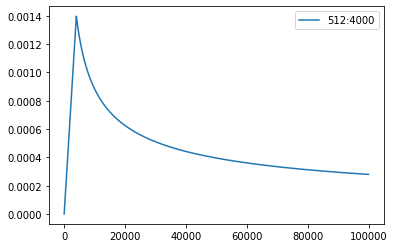

In [37]:
optimizer = NoamOpt(
    model_size=arch_args.encoder_embed_dim, 
    factor=config.lr_factor, 
    warmup=config.lr_warmup, 
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))
plt.plot(np.arange(1, 100000), [optimizer.rate(i) for i in range(1, 100000)])
plt.legend([f"{optimizer.model_size}:{optimizer.warmup}"])
None

# 訓練步驟

## Training 訓練

In [38]:
from fairseq.data import iterators
from torch.cuda.amp import GradScaler, autocast

def train_one_epoch(epoch_itr, model, task, criterion, optimizer, accum_steps=1):
    itr = epoch_itr.next_epoch_itr(shuffle=True)
    itr = iterators.GroupedIterator(itr, accum_steps) # 梯度累積: 每 accum_steps 個 sample 更新一次
    
    stats = {"loss": []}
    scaler = GradScaler() # 混和精度訓練 automatic mixed precision (amp) 
    
    model.train()
    progress = tqdm(itr, desc=f"train epoch {epoch_itr.epoch}", leave=False)
    for samples in progress:
        model.zero_grad()
        accum_loss = 0
        sample_size = 0
        # 梯度累積: 每 accum_steps 個 sample 更新一次
        for i, sample in enumerate(samples):
            if i == 1:
                # emptying the CUDA cache after the first step can reduce the chance of OOM
                torch.cuda.empty_cache()

            sample = utils.move_to_cuda(sample, device=device)
            target = sample["target"]
            sample_size_i = sample["ntokens"]
            sample_size += sample_size_i
            
            # 混和精度訓練 
            with autocast():
                net_output = model.forward(**sample["net_input"])
                lprobs = F.log_softmax(net_output[0], -1)            
                loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1))
                
                # logging
                accum_loss += loss.item()
                # back-prop
                scaler.scale(loss).backward()                
        
        scaler.unscale_(optimizer)
        optimizer.multiply_grads(1 / (sample_size or 1.0)) # (sample_size or 1.0) handles the case of a zero gradient
        gnorm = nn.utils.clip_grad_norm_(model.parameters(), config.clip_norm) # 梯度裁剪 防止梯度爆炸
        
        scaler.step(optimizer)
        scaler.update()
        
        # logging
        loss_print = accum_loss/sample_size
        stats["loss"].append(loss_print)
        progress.set_postfix(loss=loss_print)
        if config.use_wandb:
            wandb.log({
                "train/loss": loss_print,
                "train/grad_norm": gnorm.item(),
                "train/lr": optimizer.rate(),
                "train/sample_size": sample_size,
            })
        
    loss_print = np.mean(stats["loss"])
    logger.info(f"training loss: {loss_print:.4f}")
    return stats

## Validation & Inference 檢驗和推論
為防止訓練發生過度擬合，每過一段時間要做一次檢測，計算模型在未看過的資料上的表現。
- 過程基本上和training一樣，另外加上 inference
- 檢驗完畢可順便儲存模型參數

單看 validation loss，我們很難知道模型真實的效能
- 直接用當前模型去生成翻譯結果 (hypothesis)，再和正確答案 (reference) 計算 BLEU score
- 也可用肉眼看翻譯結果的好壞
- 我們用 fairseq 寫好的 sequence generator 來進行 beam search 生成翻譯結果

In [39]:
# fairseq 的 beam search generator
# 給定模型和輸入序列，用 beam search 生成翻譯結果
sequence_generator = task.build_generator([model], config)

def decode(toks, dictionary):
    # 從 Tensor 轉成人看得懂的句子
    s = dictionary.string(
        toks.int().cpu(),
        config.post_process,
    )
    return s if s else "<unk>"

def inference_step(sample, model):
    gen_out = sequence_generator.generate([model], sample)
    srcs = []
    hyps = []
    refs = []
    for i in range(len(gen_out)):
        # 對於每個 sample, 收集輸入，輸出和參考答案，稍後計算 BLEU
        srcs.append(decode(
            utils.strip_pad(sample["net_input"]["src_tokens"][i], task.source_dictionary.pad()), 
            task.source_dictionary,
        ))
        hyps.append(decode(
            gen_out[i][0]["tokens"], # 0 代表取出 beam 內分數第一的輸出結果
            task.target_dictionary,
        ))
        refs.append(decode(
            utils.strip_pad(sample["target"][i], task.target_dictionary.pad()), 
            task.target_dictionary,
        ))
    return srcs, hyps, refs

In [40]:
import shutil
import sacrebleu

def validate(model, task, criterion, log_to_wandb=True):
    logger.info('begin validation')
    itr = load_data_iterator(task, "valid", 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    stats = {"loss":[], "bleu": 0, "srcs":[], "hyps":[], "refs":[]}
    srcs = []
    hyps = []
    refs = []
    
    model.eval()
    progress = tqdm(itr, desc=f"validation", leave=False)
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)
            net_output = model.forward(**sample["net_input"])

            lprobs = F.log_softmax(net_output[0], -1)
            target = sample["target"]
            sample_size = sample["ntokens"]
            loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1)) / sample_size
            progress.set_postfix(valid_loss=loss.item())
            stats["loss"].append(loss)
            
            # 進行推論
            s, h, r = inference_step(sample, model)
            srcs.extend(s)
            hyps.extend(h)
            refs.extend(r)
            
    tok = 'zh' if task.cfg.target_lang == 'zh' else '13a'
    stats["loss"] = torch.stack(stats["loss"]).mean().item()
    stats["bleu"] = sacrebleu.corpus_bleu(hyps, [refs], tokenize=tok) # 計算BLEU score
    stats["srcs"] = srcs
    stats["hyps"] = hyps
    stats["refs"] = refs
    
    if config.use_wandb and log_to_wandb:
        wandb.log({
            "valid/loss": stats["loss"],
            "valid/bleu": stats["bleu"].score,
        }, commit=False)
    
    showid = np.random.randint(len(hyps))
    logger.info("example source: " + srcs[showid])
    logger.info("example hypothesis: " + hyps[showid])
    logger.info("example reference: " + refs[showid])
    
    # show bleu results
    logger.info(f"validation loss:\t{stats['loss']:.4f}")
    logger.info(stats["bleu"].format())
    return stats

# 儲存及載入模型參數

In [41]:
def validate_and_save(model, task, criterion, optimizer, epoch, save=True):   
    stats = validate(model, task, criterion)
    bleu = stats['bleu']
    loss = stats['loss']
    if save:
        # save epoch checkpoints
        savedir = Path(config.savedir).absolute()
        savedir.mkdir(parents=True, exist_ok=True)
        
        check = {
            "model": model.state_dict(),
            "stats": {"bleu": bleu.score, "loss": loss},
            "optim": {"step": optimizer._step}
        }
        torch.save(check, savedir/f"checkpoint{epoch}.pt")
        shutil.copy(savedir/f"checkpoint{epoch}.pt", savedir/f"checkpoint_last.pt")
        logger.info(f"saved epoch checkpoint: {savedir}/checkpoint{epoch}.pt")
    
        # save epoch samples
        with open(savedir/f"samples{epoch}.{config.source_lang}-{config.target_lang}.txt", "w") as f:
            for s, h in zip(stats["srcs"], stats["hyps"]):
                f.write(f"{s}\t{h}\n")

        # get best valid bleu    
        if getattr(validate_and_save, "best_bleu", 0) < bleu.score:
            validate_and_save.best_bleu = bleu.score
            torch.save(check, savedir/f"checkpoint_best.pt")
            
        del_file = savedir / f"checkpoint{epoch - config.keep_last_epochs}.pt"
        if del_file.exists():
            del_file.unlink()
    
    return stats

def try_load_checkpoint(model, optimizer=None, name=None):
    name = name if name else "checkpoint_last.pt"
    checkpath = Path(config.savedir)/name
    if checkpath.exists():
        check = torch.load(checkpath)
        model.load_state_dict(check["model"])
        stats = check["stats"]
        step = "unknown"
        if optimizer != None:
            optimizer._step = step = check["optim"]["step"]
        logger.info(f"loaded checkpoint {checkpath}: step={step} loss={stats['loss']} bleu={stats['bleu']}")
    else:
        logger.info(f"no checkpoints found at {checkpath}!")

# 主程式
## 訓練迴圈

In [42]:
model = model.to(device=device)
criterion = criterion.to(device=device)

In [43]:
!nvidia-smi

Thu Apr 29 15:44:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:01:00.0  On |                  N/A |
| 36%   44C    P2    63W / 250W |   1537MiB / 11016MiB |      8%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:03:00.0 Off |                  N/A |
| 42%   

In [44]:
logger.info("task: {}".format(task.__class__.__name__))
logger.info("encoder: {}".format(model.encoder.__class__.__name__))
logger.info("decoder: {}".format(model.decoder.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))
logger.info("optimizer: {}".format(optimizer.__class__.__name__))
logger.info(
    "num. model params: {:,} (num. trained: {:,})".format(
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
    )
)
logger.info(f"max tokens per batch = {config.max_tokens}, accumulate steps = {config.accum_steps}")

2021-04-29 15:45:03 | INFO | hw5.seq2seq | task: TranslationTask
2021-04-29 15:45:03 | INFO | hw5.seq2seq | encoder: TransformerEncoder
2021-04-29 15:45:03 | INFO | hw5.seq2seq | decoder: TransformerDecoder
2021-04-29 15:45:03 | INFO | hw5.seq2seq | criterion: LabelSmoothedCrossEntropyCriterion
2021-04-29 15:45:03 | INFO | hw5.seq2seq | optimizer: NoamOpt
2021-04-29 15:45:03 | INFO | hw5.seq2seq | num. model params: 52,332,544 (num. trained: 52,332,544)
2021-04-29 15:45:03 | INFO | hw5.seq2seq | max tokens per batch = 4096, accumulate steps = 4


In [45]:
epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
try_load_checkpoint(model, optimizer, name=config.resume)
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # train for one epoch
    train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
    stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
    logger.info("end of epoch {}".format(epoch_itr.epoch))    
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)

2021-04-28 22:49:55 | WARNING | fairseq.tasks.fairseq_task | 1 samples have invalid sizes and will be skipped, max_positions=(1024, 1024), first few sample ids=[326674]
2021-04-28 22:49:55 | INFO | hw5.seq2seq | no checkpoints found at checkpoints/rnn/checkpoint_last.pt!


2021-04-28 22:55:08 | INFO | hw5.seq2seq | training loss: 5.5009
2021-04-28 22:55:08 | INFO | hw5.seq2seq | begin validation


2021-04-28 22:55:51 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-28 22:55:51 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-28 22:55:51 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.


2021-04-28 22:55:51 | INFO | hw5.seq2seq | example source: 好像大家對人物比較有反應 。
2021-04-28 22:55:51 | INFO | hw5.seq2seq | example hypothesis: okay .
2021-04-28 22:55:51 | INFO | hw5.seq2seq | example reference: somehow , to people , we're slightly better at responding to that sometimes .
2021-04-28 22:55:51 | INFO | hw5.seq2seq | validation loss:	4.1163
2021-04-28 22:55:51 | INFO | hw5.seq2seq | BLEU = 4.22 32.4/7.9/2.4/0.8 (BP = 0.905 ratio = 0.909 hyp_len = 70050 ref_len = 77050)
2021-04-28 22:55:52 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn/checkpoint1.pt
2021-04-28 22:55:52 | INFO | hw5.seq2seq | end of epoch 1


2021-04-28 23:01:05 | INFO | hw5.seq2seq | training loss: 3.7383
2021-04-28 23:01:05 | INFO | hw5.seq2seq | begin validation


2021-04-28 23:01:47 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-28 23:01:47 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-28 23:01:47 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.


2021-04-28 23:01:48 | INFO | hw5.seq2seq | example source: 謝謝 。
2021-04-28 23:01:48 | INFO | hw5.seq2seq | example hypothesis: thank you very much .
2021-04-28 23:01:48 | INFO | hw5.seq2seq | example reference: thank you .
2021-04-28 23:01:48 | INFO | hw5.seq2seq | validation loss:	3.2906
2021-04-28 23:01:48 | INFO | hw5.seq2seq | BLEU = 9.68 45.7/16.7/7.4/3.6 (BP = 0.812 ratio = 0.828 hyp_len = 63790 ref_len = 77050)
2021-04-28 23:01:48 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn/checkpoint2.pt
2021-04-28 23:01:49 | INFO | hw5.seq2seq | end of epoch 2


2021-04-28 23:07:03 | INFO | hw5.seq2seq | training loss: 3.2002
2021-04-28 23:07:03 | INFO | hw5.seq2seq | begin validation


2021-04-28 23:07:45 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-28 23:07:45 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-28 23:07:45 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.


2021-04-28 23:07:45 | INFO | hw5.seq2seq | example source: 我們仍有許多要努力的地方 。
2021-04-28 23:07:45 | INFO | hw5.seq2seq | example hypothesis: we still have a lot of work .
2021-04-28 23:07:45 | INFO | hw5.seq2seq | example reference: we have some serious work still to do .
2021-04-28 23:07:45 | INFO | hw5.seq2seq | validation loss:	3.0129
2021-04-28 23:07:45 | INFO | hw5.seq2seq | BLEU = 12.67 51.4/21.4/10.5/5.3 (BP = 0.807 ratio = 0.824 hyp_len = 63466 ref_len = 77050)
2021-04-28 23:07:46 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn/checkpoint3.pt
2021-04-28 23:07:47 | INFO | hw5.seq2seq | end of epoch 3


2021-04-28 23:13:05 | INFO | hw5.seq2seq | training loss: 2.9781
2021-04-28 23:13:05 | INFO | hw5.seq2seq | begin validation


2021-04-28 23:13:47 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-28 23:13:47 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-28 23:13:47 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.


2021-04-28 23:13:48 | INFO | hw5.seq2seq | example source: 他叫丹尼班賽特 , 23年之後 , 就是這一年也是在丹尼結婚的一年我們第一次通過fda批准一種藥物可精確地修復 " 囊狀纖維化 " 的缺陷基於所有對分子的認識的基礎上 。
2021-04-28 23:13:48 | INFO | hw5.seq2seq | example hypothesis: he's a year after danny race , and that's what we've been married in danny for the first time , and for the first time , we've approved drugs to a precisely fiber based on all the foundations of molecules .
2021-04-28 23:13:48 | INFO | hw5.seq2seq | example reference: that's danny bessette , 23 years later , because this is the year , and it's also the year where danny got married , where we have , for the first time , the approval by the fda of a drug that precisely targets the defect in cystic fibrosis based upon all this molecular understanding .
2021-04-28 23:13:48 | INFO | hw5.seq2seq | validation loss:	2.8761
2021-04-28 23:13:48 | INFO | hw5.seq2seq | BLEU = 15.10 53.3/23.7/12.1/6.3 (BP = 0.856 ratio = 0.865 hyp_len = 66649 ref_len = 77050)
2021-04-28 23:13:48 | INFO | hw5.se

2021-04-28 23:19:06 | INFO | hw5.seq2seq | training loss: 2.8618
2021-04-28 23:19:06 | INFO | hw5.seq2seq | begin validation


2021-04-28 23:19:48 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-28 23:19:48 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-28 23:19:48 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.


2021-04-28 23:19:48 | INFO | hw5.seq2seq | example source: 而我身為一名訓練有素的傳染流行病學家 ,
2021-04-28 23:19:48 | INFO | hw5.seq2seq | example hypothesis: i'm a trained epidemiologist .
2021-04-28 23:19:48 | INFO | hw5.seq2seq | example reference: now , i'm an infectious disease epidemiologist by training .
2021-04-28 23:19:48 | INFO | hw5.seq2seq | validation loss:	2.7972
2021-04-28 23:19:48 | INFO | hw5.seq2seq | BLEU = 15.78 53.4/24.3/12.7/6.9 (BP = 0.859 ratio = 0.868 hyp_len = 66904 ref_len = 77050)
2021-04-28 23:19:49 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn/checkpoint5.pt
2021-04-28 23:19:50 | INFO | hw5.seq2seq | end of epoch 5


2021-04-28 23:25:07 | INFO | hw5.seq2seq | training loss: 2.7578
2021-04-28 23:25:07 | INFO | hw5.seq2seq | begin validation


2021-04-28 23:25:47 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-28 23:25:47 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-28 23:25:47 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.


2021-04-28 23:25:48 | INFO | hw5.seq2seq | example source: 我是在開玩笑 。
2021-04-28 23:25:48 | INFO | hw5.seq2seq | example hypothesis: i was joking .
2021-04-28 23:25:48 | INFO | hw5.seq2seq | example reference: i'm kidding .
2021-04-28 23:25:48 | INFO | hw5.seq2seq | validation loss:	2.7054
2021-04-28 23:25:48 | INFO | hw5.seq2seq | BLEU = 17.17 56.4/26.6/14.3/7.9 (BP = 0.845 ratio = 0.856 hyp_len = 65963 ref_len = 77050)
2021-04-28 23:25:48 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn/checkpoint6.pt
2021-04-28 23:25:49 | INFO | hw5.seq2seq | end of epoch 6


2021-04-28 23:31:05 | INFO | hw5.seq2seq | training loss: 2.6417
2021-04-28 23:31:05 | INFO | hw5.seq2seq | begin validation


2021-04-28 23:31:48 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-28 23:31:48 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-28 23:31:48 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.


2021-04-28 23:31:48 | INFO | hw5.seq2seq | example source: 就在每棟建築物間
2021-04-28 23:31:48 | INFO | hw5.seq2seq | example hypothesis: it's between every building .
2021-04-28 23:31:48 | INFO | hw5.seq2seq | example reference: it's between buildings .
2021-04-28 23:31:48 | INFO | hw5.seq2seq | validation loss:	2.6336
2021-04-28 23:31:48 | INFO | hw5.seq2seq | BLEU = 18.23 55.1/26.3/14.3/8.0 (BP = 0.902 ratio = 0.907 hyp_len = 69863 ref_len = 77050)
2021-04-28 23:31:49 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn/checkpoint7.pt
2021-04-28 23:31:50 | INFO | hw5.seq2seq | end of epoch 7


2021-04-28 23:37:05 | INFO | hw5.seq2seq | training loss: 2.5554
2021-04-28 23:37:05 | INFO | hw5.seq2seq | begin validation


2021-04-28 23:37:47 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-28 23:37:47 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-28 23:37:47 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.


2021-04-28 23:37:48 | INFO | hw5.seq2seq | example source: 城市每平方英里一天會有5到10噸的排放量
2021-04-28 23:37:48 | INFO | hw5.seq2seq | example hypothesis: cities have five to 10 tons of emissions per square mile .
2021-04-28 23:37:48 | INFO | hw5.seq2seq | example reference: that comes out at five to 10 tons daily per square mile in cities .
2021-04-28 23:37:48 | INFO | hw5.seq2seq | validation loss:	2.5916
2021-04-28 23:37:48 | INFO | hw5.seq2seq | BLEU = 18.67 56.5/27.5/15.1/8.5 (BP = 0.884 ratio = 0.890 hyp_len = 68598 ref_len = 77050)
2021-04-28 23:37:49 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn/checkpoint8.pt
2021-04-28 23:37:49 | INFO | hw5.seq2seq | end of epoch 8


2021-04-28 23:43:02 | INFO | hw5.seq2seq | training loss: 2.4863
2021-04-28 23:43:02 | INFO | hw5.seq2seq | begin validation


2021-04-28 23:43:43 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-28 23:43:43 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-28 23:43:43 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.


2021-04-28 23:43:44 | INFO | hw5.seq2seq | example source: 他們盡其所能 。
2021-04-28 23:43:44 | INFO | hw5.seq2seq | example hypothesis: they do what they can .
2021-04-28 23:43:44 | INFO | hw5.seq2seq | example reference: they got to work on what they could do .
2021-04-28 23:43:44 | INFO | hw5.seq2seq | validation loss:	2.5690
2021-04-28 23:43:44 | INFO | hw5.seq2seq | BLEU = 19.29 57.7/28.5/15.9/9.2 (BP = 0.871 ratio = 0.879 hyp_len = 67695 ref_len = 77050)
2021-04-28 23:43:45 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn/checkpoint9.pt
2021-04-28 23:43:45 | INFO | hw5.seq2seq | end of epoch 9


2021-04-28 23:48:59 | INFO | hw5.seq2seq | training loss: 2.4292
2021-04-28 23:48:59 | INFO | hw5.seq2seq | begin validation


2021-04-28 23:49:41 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-28 23:49:41 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-28 23:49:41 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.


2021-04-28 23:49:42 | INFO | hw5.seq2seq | example source: 這是我們感官的所在 , 我們特別的感官視覺、說話能力、聽覺、嗅覺、味覺 。
2021-04-28 23:49:42 | INFO | hw5.seq2seq | example hypothesis: this is where our senses are , our special sensory vision , our capacity , our hearing , our auditory , our smell , our taste .
2021-04-28 23:49:42 | INFO | hw5.seq2seq | example reference: it's where our senses are located , our special senses our vision , our speech , our hearing , our smell , our taste .
2021-04-28 23:49:42 | INFO | hw5.seq2seq | validation loss:	2.5505
2021-04-28 23:49:42 | INFO | hw5.seq2seq | BLEU = 20.19 58.0/29.1/16.5/9.7 (BP = 0.883 ratio = 0.890 hyp_len = 68547 ref_len = 77050)
2021-04-28 23:49:42 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn/checkpoint10.pt
2021-04-28 23:49:43 | INFO | hw5.seq2seq | end of epoch 10


2021-04-28 23:55:00 | INFO | hw5.seq2seq | training loss: 2.3796
2021-04-28 23:55:00 | INFO | hw5.seq2seq | begin validation


2021-04-28 23:55:42 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-28 23:55:42 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-28 23:55:42 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.


2021-04-28 23:55:42 | INFO | hw5.seq2seq | example source: 覺得 「 很溫暖 」 的則是平常的2.9倍 ,
2021-04-28 23:55:42 | INFO | hw5.seq2seq | example hypothesis: it feels like " warm " is 2 . 9 times the normal .
2021-04-28 23:55:42 | INFO | hw5.seq2seq | example reference: they're feeling " warm " at 2 . 9 times the normal level , and so on .
2021-04-28 23:55:42 | INFO | hw5.seq2seq | validation loss:	2.5328
2021-04-28 23:55:42 | INFO | hw5.seq2seq | BLEU = 20.77 57.1/28.7/16.4/9.6 (BP = 0.920 ratio = 0.923 hyp_len = 71137 ref_len = 77050)
2021-04-28 23:55:43 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn/checkpoint11.pt
2021-04-28 23:55:44 | INFO | hw5.seq2seq | end of epoch 11


2021-04-29 00:01:01 | INFO | hw5.seq2seq | training loss: 2.3372
2021-04-29 00:01:01 | INFO | hw5.seq2seq | begin validation


2021-04-29 00:01:44 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-29 00:01:44 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-29 00:01:44 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.


2021-04-29 00:01:45 | INFO | hw5.seq2seq | example source: 所以我認為好消息是雖然現今世界非常的複雜 , 但你所需做的卻非常簡單 。
2021-04-29 00:01:45 | INFO | hw5.seq2seq | example hypothesis: so i think the good news is that while the world is very , very complicated today , what you need to do is very simple .
2021-04-29 00:01:45 | INFO | hw5.seq2seq | example reference: so i think the good news is that even though the world is extremely complex , what you need to do is very simple .
2021-04-29 00:01:45 | INFO | hw5.seq2seq | validation loss:	2.5306
2021-04-29 00:01:45 | INFO | hw5.seq2seq | BLEU = 20.42 57.2/28.6/16.2/9.4 (BP = 0.914 ratio = 0.918 hyp_len = 70700 ref_len = 77050)
2021-04-29 00:01:45 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn/checkpoint12.pt
2021-04-29 00:01:45 | INFO | hw5.seq2seq | end of epoch 12


2021-04-29 00:07:01 | INFO | hw5.seq2seq | training loss: 2.2985
2021-04-29 00:07:01 | INFO | hw5.seq2seq | begin validation


2021-04-29 00:07:43 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-29 00:07:43 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-29 00:07:43 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.


2021-04-29 00:07:44 | INFO | hw5.seq2seq | example source: 另一條是離子尾 , 含帶電粒子 , 其方向遵循太陽系內磁場方向 。
2021-04-29 00:07:44 | INFO | hw5.seq2seq | example hypothesis: the other one is the ion tail , which contains charged particles , following the magnetic field of the solar system .
2021-04-29 00:07:44 | INFO | hw5.seq2seq | example reference: the other one is an ion tail , which is charged particles , and they follow the magnetic field in the solar system .
2021-04-29 00:07:44 | INFO | hw5.seq2seq | validation loss:	2.5236
2021-04-29 00:07:44 | INFO | hw5.seq2seq | BLEU = 20.85 57.6/29.1/16.7/9.8 (BP = 0.910 ratio = 0.914 hyp_len = 70411 ref_len = 77050)
2021-04-29 00:07:44 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn/checkpoint13.pt
2021-04-29 00:07:45 | INFO | hw5.seq2seq | end of epoch 13


2021-04-29 00:13:00 | INFO | hw5.seq2seq | training loss: 2.2643
2021-04-29 00:13:00 | INFO | hw5.seq2seq | begin validation


2021-04-29 00:13:41 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-29 00:13:41 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-29 00:13:41 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.


2021-04-29 00:13:42 | INFO | hw5.seq2seq | example source: 如果鬆開手 , 我會學到更多 , 能以開放和好奇的心態前進 。
2021-04-29 00:13:42 | INFO | hw5.seq2seq | example hypothesis: and if i relax , i'm going to learn more about openness and curiosity .
2021-04-29 00:13:42 | INFO | hw5.seq2seq | example reference: i learn more when i proceed and loosen my grip and proceed openly with curiosity and wonder .
2021-04-29 00:13:42 | INFO | hw5.seq2seq | validation loss:	2.5263
2021-04-29 00:13:42 | INFO | hw5.seq2seq | BLEU = 20.73 57.4/29.0/16.6/9.8 (BP = 0.910 ratio = 0.913 hyp_len = 70384 ref_len = 77050)
2021-04-29 00:13:43 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn/checkpoint14.pt
2021-04-29 00:13:43 | INFO | hw5.seq2seq | end of epoch 14


2021-04-29 00:18:59 | INFO | hw5.seq2seq | training loss: 2.2325
2021-04-29 00:18:59 | INFO | hw5.seq2seq | begin validation


2021-04-29 00:19:42 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-29 00:19:42 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-29 00:19:42 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.


2021-04-29 00:19:43 | INFO | hw5.seq2seq | example source: 我們的虛擬實境公司vrse在去年拍了15部電影我們從中學到了一些東西
2021-04-29 00:19:43 | INFO | hw5.seq2seq | example hypothesis: our virtual reality company , vrse , made 15 movies last year , and we learned something about it .
2021-04-29 00:19:43 | INFO | hw5.seq2seq | example reference: we've made 15 films in the last year at our vr company , vrse , and we've learned a few things .
2021-04-29 00:19:43 | INFO | hw5.seq2seq | validation loss:	2.5319
2021-04-29 00:19:43 | INFO | hw5.seq2seq | BLEU = 20.66 57.4/29.0/16.5/9.8 (BP = 0.908 ratio = 0.912 hyp_len = 70246 ref_len = 77050)
2021-04-29 00:19:44 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn/checkpoint15.pt
2021-04-29 00:19:44 | INFO | hw5.seq2seq | end of epoch 15


2021-04-29 00:25:00 | INFO | hw5.seq2seq | training loss: 2.2045
2021-04-29 00:25:00 | INFO | hw5.seq2seq | begin validation


2021-04-29 00:25:42 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-29 00:25:42 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-29 00:25:42 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.


2021-04-29 00:25:43 | INFO | hw5.seq2seq | example source: 因此 , 我就與德國慈善社發起了一個為期三年的計畫 , 我們訓練了30名阿富汗男女 , 我們在喀布爾創建了15個諮詢中心 。
2021-04-29 00:25:43 | INFO | hw5.seq2seq | example hypothesis: so i launched a threeyear plan with the german philanthropy , and we trained 30 men and women in afghanistan , and we created 15 consultation centers in kabul .
2021-04-29 00:25:43 | INFO | hw5.seq2seq | example reference: so , i was able to launch a threeyear project with caritas germany , and we trained 30 afghan women and men , and we opened 15 counseling centers in kabul .
2021-04-29 00:25:43 | INFO | hw5.seq2seq | validation loss:	2.5315
2021-04-29 00:25:43 | INFO | hw5.seq2seq | BLEU = 21.00 57.4/29.0/16.7/9.9 (BP = 0.916 ratio = 0.919 hyp_len = 70815 ref_len = 77050)
2021-04-29 00:25:44 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn/checkpoint16.pt
2021-04-29 00:25:44 | INFO | hw5.seq2seq | end of epoch 16


2021-04-29 00:31:03 | INFO | hw5.seq2seq | training loss: 2.1775
2021-04-29 00:31:03 | INFO | hw5.seq2seq | begin validation


2021-04-29 00:31:47 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-29 00:31:47 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-29 00:31:47 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.


2021-04-29 00:31:47 | INFO | hw5.seq2seq | example source: 我說過他們是很有冒險精神的人
2021-04-29 00:31:47 | INFO | hw5.seq2seq | example hypothesis: i said they were very adventurous people .
2021-04-29 00:31:47 | INFO | hw5.seq2seq | example reference: as i said , they were adventurous people .
2021-04-29 00:31:47 | INFO | hw5.seq2seq | validation loss:	2.5360
2021-04-29 00:31:47 | INFO | hw5.seq2seq | BLEU = 20.83 57.1/28.8/16.4/9.7 (BP = 0.921 ratio = 0.924 hyp_len = 71207 ref_len = 77050)
2021-04-29 00:31:48 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn/checkpoint17.pt
2021-04-29 00:31:48 | INFO | hw5.seq2seq | end of epoch 17


2021-04-29 00:37:06 | INFO | hw5.seq2seq | training loss: 2.1525
2021-04-29 00:37:06 | INFO | hw5.seq2seq | begin validation


2021-04-29 00:37:48 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-29 00:37:48 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-29 00:37:48 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.


2021-04-29 00:37:49 | INFO | hw5.seq2seq | example source: 這個主意其實很簡單
2021-04-29 00:37:49 | INFO | hw5.seq2seq | example hypothesis: it's a very simple idea .
2021-04-29 00:37:49 | INFO | hw5.seq2seq | example reference: the idea is very , very simple .
2021-04-29 00:37:49 | INFO | hw5.seq2seq | validation loss:	2.5480
2021-04-29 00:37:49 | INFO | hw5.seq2seq | BLEU = 20.93 58.5/29.7/17.1/10.1 (BP = 0.893 ratio = 0.898 hyp_len = 69220 ref_len = 77050)
2021-04-29 00:37:49 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn/checkpoint18.pt
2021-04-29 00:37:50 | INFO | hw5.seq2seq | end of epoch 18


2021-04-29 00:43:07 | INFO | hw5.seq2seq | training loss: 2.1302
2021-04-29 00:43:07 | INFO | hw5.seq2seq | begin validation


2021-04-29 00:43:50 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-29 00:43:50 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-29 00:43:50 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.


2021-04-29 00:43:51 | INFO | hw5.seq2seq | example source: 事實上一個在資訊安全業界的朋友幾天前告訴我說這世上只有兩種公司已被駭和還沒被駭
2021-04-29 00:43:51 | INFO | hw5.seq2seq | example hypothesis: in fact , a friend of mine in the security industry told me a few days ago that there are only two types of companies in the world that are hacked and unsca
2021-04-29 00:43:51 | INFO | hw5.seq2seq | example reference: in fact , a friend of mine from the security industry told me the other day that there are two types of companies in the world: those that know they've been hacked , and those that don't .
2021-04-29 00:43:51 | INFO | hw5.seq2seq | validation loss:	2.5522
2021-04-29 00:43:51 | INFO | hw5.seq2seq | BLEU = 20.92 57.9/29.4/16.9/10.0 (BP = 0.905 ratio = 0.909 hyp_len = 70039 ref_len = 77050)
2021-04-29 00:43:52 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn/checkpoint19.pt
2021-04-29 00:43:52 | INFO | hw5.seq2seq | end of epoch 19


2021-04-29 00:49:11 | INFO | hw5.seq2seq | training loss: 2.1087
2021-04-29 00:49:11 | INFO | hw5.seq2seq | begin validation


2021-04-29 00:49:53 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-29 00:49:53 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-29 00:49:53 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.


2021-04-29 00:49:53 | INFO | hw5.seq2seq | example source: 所以 , 下一次當隱私權受到侵害的人來找你時 , 不要責備他們 , 反之 , 我們應該這樣做:讓我們改變對數位隱私的窠臼觀點 , 以同情心、同理心來回應吧 。
2021-04-29 00:49:53 | INFO | hw5.seq2seq | example hypothesis: so the next time a privacy abuse comes to you and doesn't blame them , instead of blaming them , we should do this: let's change the way a digital privacy looks , and let's respond with compassion and empathy .
2021-04-29 00:49:53 | INFO | hw5.seq2seq | example reference: so the next time a victim of a privacy violation comes up to you , instead of blaming them , let's do this instead: let's shift our ideas about digital privacy , and let's respond with compassion .
2021-04-29 00:49:53 | INFO | hw5.seq2seq | validation loss:	2.5546
2021-04-29 00:49:53 | INFO | hw5.seq2seq | BLEU = 21.03 57.5/29.2/16.8/9.9 (BP = 0.915 ratio = 0.918 hyp_len = 70733 ref_len = 77050)
2021-04-29 00:49:54 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/r

2021-04-29 00:55:08 | INFO | hw5.seq2seq | training loss: 2.0895
2021-04-29 00:55:08 | INFO | hw5.seq2seq | begin validation


2021-04-29 00:55:49 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-29 00:55:49 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-29 00:55:49 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.


2021-04-29 00:55:50 | INFO | hw5.seq2seq | example source: 很多人 , 包括我的媽媽在內 , 都說我瘋了 。
2021-04-29 00:55:50 | INFO | hw5.seq2seq | example hypothesis: a lot of people , including my mother , said i was crazy .
2021-04-29 00:55:50 | INFO | hw5.seq2seq | example reference: many people , including my mother , said i was crazy .
2021-04-29 00:55:50 | INFO | hw5.seq2seq | validation loss:	2.5692
2021-04-29 00:55:50 | INFO | hw5.seq2seq | BLEU = 20.69 58.0/29.3/16.9/9.9 (BP = 0.896 ratio = 0.901 hyp_len = 69398 ref_len = 77050)
2021-04-29 00:55:50 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn/checkpoint21.pt
2021-04-29 00:55:50 | INFO | hw5.seq2seq | end of epoch 21


2021-04-29 01:01:04 | INFO | hw5.seq2seq | training loss: 2.0699
2021-04-29 01:01:04 | INFO | hw5.seq2seq | begin validation


2021-04-29 01:01:45 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-29 01:01:45 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-29 01:01:45 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.


2021-04-29 01:01:46 | INFO | hw5.seq2seq | example source: 而應該將主要精力放在知識創造上 。
2021-04-29 01:01:46 | INFO | hw5.seq2seq | example hypothesis: and we should focus primarily on creating knowledge .
2021-04-29 01:01:46 | INFO | hw5.seq2seq | example reference: they should be dedicated mainly to knowledge production .
2021-04-29 01:01:46 | INFO | hw5.seq2seq | validation loss:	2.5845
2021-04-29 01:01:46 | INFO | hw5.seq2seq | BLEU = 21.16 57.9/29.5/17.0/10.2 (BP = 0.908 ratio = 0.912 hyp_len = 70251 ref_len = 77050)
2021-04-29 01:01:46 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn/checkpoint22.pt
2021-04-29 01:01:47 | INFO | hw5.seq2seq | end of epoch 22


2021-04-29 01:07:00 | INFO | hw5.seq2seq | training loss: 2.0528
2021-04-29 01:07:00 | INFO | hw5.seq2seq | begin validation


2021-04-29 01:07:42 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-29 01:07:42 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-29 01:07:42 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.


2021-04-29 01:07:43 | INFO | hw5.seq2seq | example source: 我想這項科技的運用讓道格拉斯.諾斯感到驚訝的地方 , 應該就是區塊鏈技術真的辦到了 , 而讓區塊鏈維持安全且易確證的原因就是我們彼此的不信任 。
2021-04-29 01:07:43 | INFO | hw5.seq2seq | example hypothesis: and i think what surprised douglas noses , i think , was that blockchain technology really did it , and the reason that blockchains stay safe and clear is that we distrust each other .
2021-04-29 01:07:43 | INFO | hw5.seq2seq | example reference: i think what would probably floor douglass north about this use of technology is the fact that the very thing that makes it work , the very thing that keeps the blockchain secure and verified , is our mutual distrust .
2021-04-29 01:07:43 | INFO | hw5.seq2seq | validation loss:	2.5860
2021-04-29 01:07:43 | INFO | hw5.seq2seq | BLEU = 20.94 58.3/29.6/17.2/10.3 (BP = 0.891 ratio = 0.897 hyp_len = 69091 ref_len = 77050)
2021-04-29 01:07:44 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn/checkpoi

2021-04-29 01:12:58 | INFO | hw5.seq2seq | training loss: 2.0361
2021-04-29 01:12:58 | INFO | hw5.seq2seq | begin validation


2021-04-29 01:13:39 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-29 01:13:39 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-29 01:13:39 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.


2021-04-29 01:13:40 | INFO | hw5.seq2seq | example source: 在那種情況下 , 我們可能會在給法院的信中建議發給緩刑者條列重要訊息的講義 。
2021-04-29 01:13:40 | INFO | hw5.seq2seq | example hypothesis: in that situation , we could recommend key messages to the probationer in court advice .
2021-04-29 01:13:40 | INFO | hw5.seq2seq | example reference: in that case , our letter to the court might suggest that that probationer get handouts of important information .
2021-04-29 01:13:40 | INFO | hw5.seq2seq | validation loss:	2.5935
2021-04-29 01:13:40 | INFO | hw5.seq2seq | BLEU = 21.22 57.2/29.0/16.7/10.0 (BP = 0.924 ratio = 0.927 hyp_len = 71435 ref_len = 77050)
2021-04-29 01:13:41 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn/checkpoint24.pt
2021-04-29 01:13:41 | INFO | hw5.seq2seq | end of epoch 24


2021-04-29 01:18:54 | INFO | hw5.seq2seq | training loss: 2.0206
2021-04-29 01:18:54 | INFO | hw5.seq2seq | begin validation


2021-04-29 01:19:35 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-29 01:19:35 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-29 01:19:35 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.


2021-04-29 01:19:36 | INFO | hw5.seq2seq | example source: 因此我們就先開始了一個臉書網頁 , 然後一個宣言 , 然後以一個非常簡單的方式 , 從街道開始報導 。
2021-04-29 01:19:36 | INFO | hw5.seq2seq | example hypothesis: so we started with a facebook page , and then announcing , and then reporting on the street in a very simple way .
2021-04-29 01:19:36 | INFO | hw5.seq2seq | example reference: so we launched a facebook page first , and then a manifesto , and started to cover the streets in a very simple way .
2021-04-29 01:19:36 | INFO | hw5.seq2seq | validation loss:	2.5991
2021-04-29 01:19:36 | INFO | hw5.seq2seq | BLEU = 20.95 57.7/29.3/16.8/10.0 (BP = 0.908 ratio = 0.912 hyp_len = 70264 ref_len = 77050)
2021-04-29 01:19:37 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn/checkpoint25.pt
2021-04-29 01:19:37 | INFO | hw5.seq2seq | end of epoch 25


2021-04-29 01:24:50 | INFO | hw5.seq2seq | training loss: 2.0052
2021-04-29 01:24:50 | INFO | hw5.seq2seq | begin validation


2021-04-29 01:25:32 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-29 01:25:32 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-29 01:25:32 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.


2021-04-29 01:25:33 | INFO | hw5.seq2seq | example source: 你的戒指呢 ?
2021-04-29 01:25:33 | INFO | hw5.seq2seq | example hypothesis: what about your ring ?
2021-04-29 01:25:33 | INFO | hw5.seq2seq | example reference: do you have a ring as well ?
2021-04-29 01:25:33 | INFO | hw5.seq2seq | validation loss:	2.6062
2021-04-29 01:25:33 | INFO | hw5.seq2seq | BLEU = 21.10 56.6/28.4/16.3/9.6 (BP = 0.941 ratio = 0.943 hyp_len = 72650 ref_len = 77050)
2021-04-29 01:25:33 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn/checkpoint26.pt
2021-04-29 01:25:33 | INFO | hw5.seq2seq | end of epoch 26


2021-04-29 01:30:47 | INFO | hw5.seq2seq | training loss: 1.9911
2021-04-29 01:30:47 | INFO | hw5.seq2seq | begin validation


2021-04-29 01:31:29 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-29 01:31:29 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-29 01:31:29 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.


2021-04-29 01:31:29 | INFO | hw5.seq2seq | example source: 我們無意要搞笑 , 我們也不是打算...不 , 應該說我們本來只打算搞笑
2021-04-29 01:31:29 | INFO | hw5.seq2seq | example hypothesis: we're not trying to be funny , we're not trying to no , we're just trying to be funny .
2021-04-29 01:31:29 | INFO | hw5.seq2seq | example reference: we weren't trying to be funny , we weren't trying to be well , we were trying to be funny actually , that's not true .
2021-04-29 01:31:29 | INFO | hw5.seq2seq | validation loss:	2.6226
2021-04-29 01:31:29 | INFO | hw5.seq2seq | BLEU = 20.98 57.2/28.8/16.6/9.9 (BP = 0.921 ratio = 0.924 hyp_len = 71169 ref_len = 77050)
2021-04-29 01:31:30 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn/checkpoint27.pt
2021-04-29 01:31:30 | INFO | hw5.seq2seq | end of epoch 27


2021-04-29 01:36:44 | INFO | hw5.seq2seq | training loss: 1.9775
2021-04-29 01:36:44 | INFO | hw5.seq2seq | begin validation


2021-04-29 01:37:27 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-29 01:37:27 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-29 01:37:27 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.


2021-04-29 01:37:27 | INFO | hw5.seq2seq | example source: 你要做的 , 就是把你的問題和以前別人所遇到的問題做比對 , 再利用他們已經想出的辦法來解決 。
2021-04-29 01:37:27 | INFO | hw5.seq2seq | example hypothesis: what you have to do is contrast your problems with the problems that people have faced before and harness them to the solutions they've come up with .
2021-04-29 01:37:27 | INFO | hw5.seq2seq | example reference: because what you can do is take your problem , and turn it into a problem that someone else has solved , and use their solutions .
2021-04-29 01:37:27 | INFO | hw5.seq2seq | validation loss:	2.6241
2021-04-29 01:37:27 | INFO | hw5.seq2seq | BLEU = 21.01 56.8/28.5/16.3/9.7 (BP = 0.934 ratio = 0.936 hyp_len = 72103 ref_len = 77050)
2021-04-29 01:37:28 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn/checkpoint28.pt
2021-04-29 01:37:28 | INFO | hw5.seq2seq | end of epoch 28


2021-04-29 01:42:42 | INFO | hw5.seq2seq | training loss: 1.9645
2021-04-29 01:42:42 | INFO | hw5.seq2seq | begin validation


2021-04-29 01:43:25 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-29 01:43:25 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-29 01:43:25 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.


2021-04-29 01:43:26 | INFO | hw5.seq2seq | example source: 這就能製造出幻覺來欺騙大腦 , 讓大腦認為想像的瘙癢感已經被解決了 。
2021-04-29 01:43:26 | INFO | hw5.seq2seq | example hypothesis: this creates hallucinations in order to trick the brain away from the itchy imagination that the imagination has been resolved .
2021-04-29 01:43:26 | INFO | hw5.seq2seq | example reference: that creates an illusion that tricks the brain into thinking the imaginary itch has been satisfied .
2021-04-29 01:43:26 | INFO | hw5.seq2seq | validation loss:	2.6338
2021-04-29 01:43:26 | INFO | hw5.seq2seq | BLEU = 20.91 56.9/28.7/16.4/9.8 (BP = 0.923 ratio = 0.926 hyp_len = 71370 ref_len = 77050)
2021-04-29 01:43:27 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn/checkpoint29.pt
2021-04-29 01:43:27 | INFO | hw5.seq2seq | end of epoch 29


2021-04-29 01:48:45 | INFO | hw5.seq2seq | training loss: 1.9530
2021-04-29 01:48:45 | INFO | hw5.seq2seq | begin validation


2021-04-29 01:49:28 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-29 01:49:28 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-29 01:49:28 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.


2021-04-29 01:49:28 | INFO | hw5.seq2seq | example source: 你認為我們必須要延遲多久時間為使這種抑制效應無效而這種效應就是知道教職員會看見你的答案 ?
2021-04-29 01:49:28 | INFO | hw5.seq2seq | example hypothesis: how long do you think we have to delay to make this institutional effective , and that effect is knowing that the faculty can see your answers ?
2021-04-29 01:49:28 | INFO | hw5.seq2seq | example reference: how long a delay do you think we had to add in order to nullify the inhibitory effect of knowing that faculty would see your answers ?
2021-04-29 01:49:28 | INFO | hw5.seq2seq | validation loss:	2.6409
2021-04-29 01:49:28 | INFO | hw5.seq2seq | BLEU = 20.69 56.9/28.5/16.3/9.6 (BP = 0.922 ratio = 0.925 hyp_len = 71296 ref_len = 77050)
2021-04-29 01:49:29 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn/checkpoint30.pt
2021-04-29 01:49:29 | INFO | hw5.seq2seq | end of epoch 30


# Submission 繳交檔案

In [45]:
# 把幾個 checkpoint 平均起來可以達到 ensemble 的效果
checkdir=config.savedir
!python3 ./fairseq/scripts/average_checkpoints.py \
--inputs {checkdir} \
--num-epoch-checkpoints 5 \
--output {checkdir}/avg_last_5_checkpoint.pt

Namespace(checkpoint_upper_bound=None, inputs=['./checkpoints/rnn'], num_epoch_checkpoints=5, num_update_checkpoints=None, output='./checkpoints/rnn/avg_last_5_checkpoint.pt')
averaging checkpoints:  ['./checkpoints/rnn/checkpoint30.pt', './checkpoints/rnn/checkpoint29.pt', './checkpoints/rnn/checkpoint28.pt', './checkpoints/rnn/checkpoint27.pt', './checkpoints/rnn/checkpoint26.pt']
Finished writing averaged checkpoint to ./checkpoints/rnn/avg_last_5_checkpoint.pt


## 確認生成繳交檔案的模型參數

In [46]:
# checkpoint_last.pt : 最後一次檢驗的檔案
# checkpoint_best.pt : 檢驗 BLEU 最高的檔案
# avg_last_5_checkpoint.pt:　最5後個檔案平均
try_load_checkpoint(model, name="avg_last_5_checkpoint.pt")
validate(model, task, criterion, log_to_wandb=False)
None

2021-04-29 15:45:13 | INFO | hw5.seq2seq | loaded checkpoint checkpoints/rnn/avg_last_5_checkpoint.pt: step=unknown loss=2.640942335128784 bleu=20.69289644689053
2021-04-29 15:45:13 | INFO | hw5.seq2seq | begin validation


2021-04-29 15:45:53 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-29 15:45:53 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-29 15:45:53 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.


2021-04-29 15:45:54 | INFO | hw5.seq2seq | example source: 好像大家對人物比較有反應 。
2021-04-29 15:45:54 | INFO | hw5.seq2seq | example hypothesis: it's like people are more responsive to the characters .
2021-04-29 15:45:54 | INFO | hw5.seq2seq | example reference: somehow , to people , we're slightly better at responding to that sometimes .
2021-04-29 15:45:54 | INFO | hw5.seq2seq | validation loss:	2.5965
2021-04-29 15:45:54 | INFO | hw5.seq2seq | BLEU = 21.48 57.5/29.3/17.0/10.1 (BP = 0.926 ratio = 0.929 hyp_len = 71547 ref_len = 77050)


### 下載 monolingual data

In [47]:
mono_dataset_name = 'mono'

In [48]:
mono_prefix = Path(data_dir).absolute() / mono_dataset_name
mono_prefix.mkdir(parents=True, exist_ok=True)
print(mono_prefix)
print(prefix)
urls = (
    '"https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214986&authkey=AANUKbGfZx0kM80"',
# # If the above links die, use the following instead. 
#     "https://www.csie.ntu.edu.tw/~r09922057/ML2021-hw5/ted_zh_corpus.deduped.gz",
# # If the above links die, use the following instead. 
#     "https://mega.nz/#!vMNnDShR!4eHDxzlpzIpdpeQTD-htatU_C7QwcBTwGDaSeBqH534",
)
file_names = (
    'ted_zh_corpus.deduped.gz',
)

for u, f in zip(urls, file_names):
    path = mono_prefix/f
    if not path.exists():
        if 'mega' in u:
            !megadl {u} --path {path}
        else:
            !wget {u} -O {path}
    else:
        print(f'{f} is exist, skip downloading')
    if path.suffix == ".tgz":
        !tar -xvf {path} -C {prefix}
    elif path.suffix == ".zip":
        !unzip -o {path} -d {prefix}
    elif path.suffix == ".gz":
        !gzip -fkd {path}

/home/bill/Desktop/Graduate_course/ML2021/hw5/DATA/rawdata/mono
/home/bill/Desktop/Graduate_course/ML2021/hw5/DATA/rawdata/ted2020
ted_zh_corpus.deduped.gz is exist, skip downloading


### TODO: 清理資料集

1. 將太長、太短的句子移除
2. 統一標點符號

hint: 可以使用clean_s()來協助

In [49]:
src_lang = 'zh'
tgt_lang = 'en'


def strQ2B(ustring):
    """把字串全形轉半形"""
    # 參考來源:https://ithelp.ithome.com.tw/articles/10233122
    ss = []
    for s in ustring:
        rstring = ""
        for uchar in s:
            inside_code = ord(uchar)
            if inside_code == 12288:  # 全形空格直接轉換
                inside_code = 32
            elif (inside_code >= 65281 and inside_code <= 65374):  # 全形字元（除空格）根據關係轉化
                inside_code -= 65248
            rstring += chr(inside_code)
        ss.append(rstring)
    return ''.join(ss)
                
def clean_s(s, lang):
    if lang == 'en':
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace('-', '') # remove '-'
        s = re.sub('([.,;!?()\"])', r' \1 ', s) # keep punctuation
    elif lang == 'zh':
        s = strQ2B(s) # Q2B
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace(' ', '')
        s = s.replace('—', '')
        s = s.replace('“', '"')
        s = s.replace('”', '"')
        s = s.replace('_', '')
        s = re.sub('([。,;!?()\"~「」])', r' \1 ', s) # keep punctuation
    s = ' '.join(s.strip().split())
    return s

def len_s(s, lang):
    if lang == 'zh':
        return len(s)
    return len(s.split())

def clean_corpus(prefix, l1, l2, ratio=9, max_len=1000, min_len=1):
    if Path(f'{prefix}.clean.{l1}').exists() and Path(f'{prefix}.clean.{l2}').exists():
        print(f'{prefix}.clean.{l1} & {l2} exists. skipping clean.')
        return
    with open(f'{prefix}', 'r') as l1_in_f:
            with open(f'{prefix}.clean.{l1}', 'w') as l1_out_f:
                    for s1 in l1_in_f:
                        s1 = s1.strip()
                        
                        s1 = clean_s(s1, l1)
                        
                        s1_len = len_s(s1, l1)
                        
                        if min_len > 0: # remove short sentence
                            if s1_len < min_len or s2_len < min_len:
                                continue
                        if max_len > 0: # remove long sentence
                            if s1_len > max_len or s2_len > max_len:
                                continue
#                         if ratio > 0: # remove by ratio of length
#                             if s1_len/s2_len > ratio or s2_len/s1_len > ratio:
#                                 continue
                        print(s1, file=l1_out_f)
                        
print(f'{mono_prefix}' + '/ted_zh_corpus.deduped')
clean_corpus(f'{mono_prefix}' + '/ted_zh_corpus.deduped', src_lang, tgt_lang, ratio=-1, min_len=-1, max_len=-1)

/home/bill/Desktop/Graduate_course/ML2021/hw5/DATA/rawdata/mono/ted_zh_corpus.deduped
/home/bill/Desktop/Graduate_course/ML2021/hw5/DATA/rawdata/mono/ted_zh_corpus.deduped.clean.zh & en exists. skipping clean.


## 進行預測

In [50]:
def generate_prediction(model, task, split="test", outfile="./prediction.txt"):    
    task.load_dataset(split=split, epoch=1)
    itr = load_data_iterator(task, split, 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    idxs = []
    hyps = []

    model.eval()
    progress = tqdm(itr, desc=f"prediction")
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)

            # 進行推論
            s, h, r = inference_step(sample, model)
            
            hyps.extend(h)
            idxs.extend(list(sample['id']))
            
    # 根據 preprocess 時的順序排列
    hyps = [x for _,x in sorted(zip(idxs,hyps))]
    
    with open(outfile, "w") as f:
        for h in hyps:
            f.write(h+"\n")

### TODO: Subword Units

用反向模型的 spm model 將資料切成 subword units

hint: spm model 的路徑為 DATA/raw-data/\[dataset\]/spm\[vocab_num\].model

In [51]:
with open(mono_prefix/'ted_zh_corpus.deduped.clean.en', 'w') as out_f:
    with open(mono_prefix/'ted_zh_corpus.deduped.clean.zh', 'r') as in_f:
        for line in in_f:
            out_f.write('.\n')

In [52]:
spm_model = spm.SentencePieceProcessor(model_file=str(prefix/f'spm{vocab_size}.model'))
in_tag = {
    'train': 'ted_zh_corpus.deduped.clean',
}
for split in ['train']:
    for lang in [src_lang, tgt_lang]:
        out_path = mono_prefix/f'{split}.{lang}'
        if out_path.exists():
            print(f"{out_path} exists. skipping spm_encode.")
        else:
            with open(mono_prefix/f'{split}.{lang}', 'w') as out_f:
                with open(mono_prefix/f'{in_tag[split]}.{lang}', 'r') as in_f:
                    for line in in_f:
                        line = line.strip()
                        tok = spm_model.encode(line, out_type=str)
                        print(' '.join(tok), file=out_f)

/home/bill/Desktop/Graduate_course/ML2021/hw5/DATA/rawdata/mono/train.zh exists. skipping spm_encode.
/home/bill/Desktop/Graduate_course/ML2021/hw5/DATA/rawdata/mono/train.en exists. skipping spm_encode.


### Binarize

使用fairseq將資料轉為binary

In [54]:
binpath = Path('./DATA/data-bin', mono_dataset_name)
src_dict_file = './DATA/data-bin/ted2020/dict.zh.txt'
tgt_dict_file = src_dict_file
monopref = str(mono_prefix/"mono.tok") # whatever filepath you get after applying subword tokenization
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python3 -m fairseq_cli.preprocess\
        --source-lang 'zh'\
        --target-lang 'en'\
        --trainpref {mono_prefix/'train'}\
        --destdir {binpath}\
        --srcdict {src_dict_file}\
        --tgtdict {tgt_dict_file}\
        --workers 1

2021-04-29 15:46:54 | INFO | fairseq_cli.preprocess | Namespace(align_suffix=None, alignfile=None, all_gather_list_size=16384, azureml_logging=False, bf16=False, bpe=None, cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='DATA/data-bin/mono', empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=False, log_format=None, log_interval=100, lr_scheduler='fixed', memory_efficient_bf16=False, memory_efficient_fp16=False, min_loss_scale=0.0001, model_parallel_size=1, no_progress_bar=False, nwordssrc=-1, nwordstgt=-1, only_source=False, optimizer=None, padding_factor=8, profile=False, quantization_config_path=None, reset_logging=False, scoring='bleu', seed=1, source_lang='zh', srcdict='./DATA/data-bin/ted2020/dict.zh.txt', suppress_crashes=False, target_lang='en', task='translation', tensorboard_logdir=None, testpref=None, tgtdict='./DATA/data-bin/ted2020/dict.zh.txt', threshold_lo

## 利用反向模型生成額外資料

### TODO: 生成反向翻譯資料

將 binarized data 加入原本的資料夾中並用一個 split_name 取名

ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]

便可以使用 generate_prediction(model, task, split="split_name")來產生翻譯資料

In [55]:
# 將 binarized data 加入原本的資料夾中並用一個 split_name 取名
# ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]
!cp ./DATA/data-bin/mono/train.zh-en.zh.bin ./DATA/data-bin/ted2020/mono.zh-en.zh.bin
!cp ./DATA/data-bin/mono/train.zh-en.zh.idx ./DATA/data-bin/ted2020/mono.zh-en.zh.idx
!cp ./DATA/data-bin/mono/train.zh-en.en.bin ./DATA/data-bin/ted2020/mono.zh-en.en.bin
!cp ./DATA/data-bin/mono/train.zh-en.en.idx ./DATA/data-bin/ted2020/mono.zh-en.en.idx

In [56]:
generate_prediction( model, task, split='mono', outfile='./prediction_file.en' )

2021-04-29 13:54:55 | INFO | fairseq.data.data_utils | loaded 782,527 examples from: ./DATA/data-bin/ted2020/mono.zh-en.zh
2021-04-29 13:54:55 | INFO | fairseq.data.data_utils | loaded 782,527 examples from: ./DATA/data-bin/ted2020/mono.zh-en.en
2021-04-29 13:54:55 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 mono zh-en 782527 examples


prediction: 100%|██████████| 3533/3533 [1:19:16<00:00,  1.35s/it]


# Back-translation

## 訓練一個反向的翻譯模型

1. 將實驗的參數設定表中(config)的source_lang與target_lang互相交換
2. 將實驗的參數設定表中(config)的savedir更改(ex. "./checkpoints/rnn-back")
3. 訓練一個反向模型

In [ ]:
# hint: 用反向模型在 split='mono' 上進行預測，生成 prediction_file


### TODO: 產生新的dataset

1. 將翻譯出來的資料與原先的訓練資料結合
2. 使用之前的spm model切出成Subword Units
3. 重新使用fairseq將資料轉為binary

In [56]:
# 合併剛剛生成的 prediction_file (.en) 以及中文 mono.zh (.zh)
# 
# hint: 在此用剛剛的 spm model 對 prediction_file 進行切斷詞
!cp ./DATA/rawdata/mono/train.zh ./DATA/rawdata/mono/mono.tok.zh

spm_model = spm.SentencePieceProcessor(model_file=str(prefix/f'spm{vocab_size}.model'))
in_tag = {
    'train': 'prediction_file.en',
}
t_f = 'mono.tok.en'
for split in ['train']:
    for lang in [tgt_lang]:
        out_path = mono_prefix/t_f
        if out_path.exists():
            print(f"{out_path} exists. skipping spm_encode.")
        else:
            with open(mono_prefix/t_f, 'w') as out_f:
                with open('./prediction_file.en', 'r') as in_f:
                    for line in in_f:
                        line = line.strip()
                        tok = spm_model.encode(line, out_type=str)
                        print(' '.join(tok), file=out_f)
# output: ./DATA/rawdata/mono/mono.tok.en & mono.tok.zh

# hint: 在此用 fairseq 把這些檔案再 binarize
binpath = Path('./DATA/data-bin/synthetic')
src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
tgt_dict_file = src_dict_file

if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python3 -m fairseq_cli.preprocess\
        --source-lang 'zh'\
        --target-lang 'en'\
        --trainpref {mono_prefix/'mono.tok'}\
        --destdir {binpath}\
        --srcdict {src_dict_file}\
        --tgtdict {tgt_dict_file}\
        --workers 1

/home/bill/Desktop/Graduate_course/ML2021/hw5/DATA/rawdata/mono/mono.tok.en exists. skipping spm_encode.
2021-04-29 15:47:57 | INFO | fairseq_cli.preprocess | Namespace(align_suffix=None, alignfile=None, all_gather_list_size=16384, azureml_logging=False, bf16=False, bpe=None, cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='DATA/data-bin/synthetic', empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=False, log_format=None, log_interval=100, lr_scheduler='fixed', memory_efficient_bf16=False, memory_efficient_fp16=False, min_loss_scale=0.0001, model_parallel_size=1, no_progress_bar=False, nwordssrc=-1, nwordstgt=-1, only_source=False, optimizer=None, padding_factor=8, profile=False, quantization_config_path=None, reset_logging=False, scoring='bleu', seed=1, source_lang='zh', srcdict='./DATA/data-bin/ted2020/dict.en.txt', suppress_crashes=False, target_lang='en', task='tra

In [57]:
# 這裡用剛剛準備的檔案合併原先 ted2020 來生成最終 back-translation 的資料
!cp -r ./DATA/data-bin/ted2020/ ./DATA/data-bin/ted2020_with_mono/

!cp ./DATA/data-bin/synthetic/train.zh-en.zh.bin ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh.bin
!cp ./DATA/data-bin/synthetic/train.zh-en.zh.idx ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh.idx
!cp ./DATA/data-bin/synthetic/train.zh-en.en.bin ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en.bin
!cp ./DATA/data-bin/synthetic/train.zh-en.en.idx ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en.idx

### TODO: 重新訓練

當已經產生新的資料集

1. 將實驗的參數設定表(config)中的datadir改為新的資料集("./DATA/data-bin/ted2020_with_mono")
2. 將實驗的參數設定表(config)中的source_lang與target_lang設定還原("en", "zh")
3. 將實驗的參數設定表(config)中的savedir更改(ex. "./checkpoints/rnn-bt")
4. 重新訓練

In [58]:
config = Namespace(
    datadir = "./DATA/data-bin/ted2020_with_mono",
    savedir = "./checkpoints/rnn-bt",
    source_lang = "en",
    target_lang = "zh",
    
    # cpu threads when fetching & processing data.
    num_workers=1,  
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    max_tokens=4096,
    accum_steps=4,
    
    # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=2.,
    lr_warmup=4000,
    
    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0,
    
    # maximum epochs for training
    max_epoch=30,
    start_epoch=1,
    
    # beam size for beam search
    beam=5, 
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2, 
    max_len_b=10,
    # when decoding, post process sentence by removing sentencepiece symbols.
    post_process = "sentencepiece",
    
    # checkpoints
    keep_last_epochs=5,
    resume=None, # if resume from checkpoint name (under config.savedir)
    
    # logging
    use_wandb=False,
)

In [59]:
logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level="INFO", # "DEBUG" "WARNING" "ERROR"
    stream=sys.stdout,
)
proj = "hw5.seq2seq"
logger = logging.getLogger(proj)
if config.use_wandb:
    import wandb
    wandb.init(project=proj, name=Path(config.savedir).stem, config=config)

In [60]:
from fairseq.tasks.translation import TranslationConfig, TranslationTask

## setup task
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2021-04-29 15:49:52 | INFO | fairseq.tasks.translation | [en] dictionary: 8000 types
2021-04-29 15:49:52 | INFO | fairseq.tasks.translation | [zh] dictionary: 8000 types


In [61]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2021-04-29 15:49:55 | INFO | hw5.seq2seq | loading data for epoch 1
2021-04-29 15:49:55 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020_with_mono/train.zh-en.en
2021-04-29 15:49:55 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020_with_mono/train.zh-en.zh
2021-04-29 15:49:55 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020_with_mono train en-zh 390041 examples
2021-04-29 15:49:55 | INFO | fairseq.data.data_utils | loaded 782,527 examples from: ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en
2021-04-29 15:49:55 | INFO | fairseq.data.data_utils | loaded 782,527 examples from: ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh
2021-04-29 15:49:55 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020_with_mono train1 en-zh 782527 examples
2021-04-29 15:49:55 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020_with_mono/valid.zh-en.en
2021-04-29 15:49:55 | I

In [62]:
model = model.to(device=device)
criterion = criterion.to(device=device)

In [63]:
epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
try_load_checkpoint(model, optimizer, name=config.resume)
print(epoch_itr.next_epoch_idx)
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # train for one epoch
    train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
    stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
    logger.info("end of epoch {}".format(epoch_itr.epoch))    
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)

2021-04-29 15:50:00 | WARNING | fairseq.tasks.fairseq_task | 1 samples have invalid sizes and will be skipped, max_positions=(1024, 1024), first few sample ids=[326674]
2021-04-29 15:50:00 | INFO | hw5.seq2seq | no checkpoints found at checkpoints/rnn-bt/checkpoint_last.pt!


train epoch 1:   0%|          | 0/1894 [00:00<?, ?it/s]

1


2021-04-29 16:02:01 | INFO | hw5.seq2seq | training loss: 5.1597
2021-04-29 16:02:01 | INFO | hw5.seq2seq | begin validation


2021-04-29 16:02:37 | INFO | hw5.seq2seq | example source: thank you . thank you .
2021-04-29 16:02:37 | INFO | hw5.seq2seq | example hypothesis: 謝謝 。 謝謝 。
2021-04-29 16:02:37 | INFO | hw5.seq2seq | example reference: 謝謝 。 謝謝 。
2021-04-29 16:02:37 | INFO | hw5.seq2seq | validation loss:	3.8400
2021-04-29 16:02:37 | INFO | hw5.seq2seq | BLEU = 20.28 53.7/27.7/15.0/8.7 (BP = 0.967 ratio = 0.968 hyp_len = 108212 ref_len = 111811)
2021-04-29 16:02:37 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn-bt/checkpoint1.pt
2021-04-29 16:02:37 | INFO | hw5.seq2seq | end of epoch 1


2021-04-29 16:14:42 | INFO | hw5.seq2seq | training loss: 3.3194
2021-04-29 16:14:42 | INFO | hw5.seq2seq | begin validation


2021-04-29 16:15:18 | INFO | hw5.seq2seq | example source: but you know what happened to my country .
2021-04-29 16:15:18 | INFO | hw5.seq2seq | example hypothesis: 但是你知道我國家發生了什麼事 。
2021-04-29 16:15:18 | INFO | hw5.seq2seq | example reference: 但是你們都知道我的國家發生了什麼 。
2021-04-29 16:15:18 | INFO | hw5.seq2seq | validation loss:	3.4332
2021-04-29 16:15:18 | INFO | hw5.seq2seq | BLEU = 23.55 56.8/31.1/17.8/10.7 (BP = 0.977 ratio = 0.978 hyp_len = 109300 ref_len = 111811)
2021-04-29 16:15:18 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn-bt/checkpoint2.pt
2021-04-29 16:15:19 | INFO | hw5.seq2seq | end of epoch 2


2021-04-29 16:27:24 | INFO | hw5.seq2seq | training loss: 3.0446
2021-04-29 16:27:24 | INFO | hw5.seq2seq | begin validation


2021-04-29 16:28:01 | INFO | hw5.seq2seq | example source: if we look at the selectivity of responses in the cortex of the monkey , we see that the monkey has actually changed the filter characteristics which represents input from the skin of the fingertips that are engaged .
2021-04-29 16:28:01 | INFO | hw5.seq2seq | example hypothesis: 如果我們看看猴子皮層的選擇性 , 我們會發現猴子其實已經改變過濾器的特徵 , 可以從手指的皮膚中輸入 。
2021-04-29 16:28:01 | INFO | hw5.seq2seq | example reference: 假如我們看到猴子的大腦皮層中 , 對應這些動作的區域有反應 , 我們可以看到猴子正利用從指尖皮膚執行動作時的回饋訊號 , 來調整 , 建立適當的過濾器 。
2021-04-29 16:28:01 | INFO | hw5.seq2seq | validation loss:	3.2194
2021-04-29 16:28:01 | INFO | hw5.seq2seq | BLEU = 25.50 57.9/32.8/19.5/12.1 (BP = 0.985 ratio = 0.985 hyp_len = 110178 ref_len = 111811)
2021-04-29 16:28:01 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn-bt/checkpoint3.pt
2021-04-29 16:28:02 | INFO | hw5.seq2seq | end of epoch 3


2021-04-29 16:40:08 | INFO | hw5.seq2seq | training loss: 2.8821
2021-04-29 16:40:08 | INFO | hw5.seq2seq | begin validation


2021-04-29 16:40:42 | INFO | hw5.seq2seq | example source: and then he said , " why would they vote for him ? "
2021-04-29 16:40:42 | INFO | hw5.seq2seq | example hypothesis: 然後他說: 「 為什麼他們會投票給他 ? 」
2021-04-29 16:40:42 | INFO | hw5.seq2seq | example reference: 接著他說: 「 他們為何投給他 ? 」
2021-04-29 16:40:42 | INFO | hw5.seq2seq | validation loss:	3.1373
2021-04-29 16:40:42 | INFO | hw5.seq2seq | BLEU = 26.01 59.7/34.5/20.8/13.0 (BP = 0.952 ratio = 0.953 hyp_len = 106542 ref_len = 111811)
2021-04-29 16:40:43 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn-bt/checkpoint4.pt
2021-04-29 16:40:44 | INFO | hw5.seq2seq | end of epoch 4


2021-04-29 16:52:49 | INFO | hw5.seq2seq | training loss: 2.7851
2021-04-29 16:52:49 | INFO | hw5.seq2seq | begin validation


2021-04-29 16:53:26 | INFO | hw5.seq2seq | example source: lp: yeah , absolutely .
2021-04-29 16:53:26 | INFO | hw5.seq2seq | example hypothesis: 賴瑞.佩吉:是的 , 絕對是 。
2021-04-29 16:53:26 | INFO | hw5.seq2seq | example reference: 賴瑞.佩吉:是的 , 毫無疑問 。
2021-04-29 16:53:26 | INFO | hw5.seq2seq | validation loss:	3.0751
2021-04-29 16:53:26 | INFO | hw5.seq2seq | BLEU = 26.99 58.9/34.1/20.8/13.2 (BP = 0.989 ratio = 0.989 hyp_len = 110636 ref_len = 111811)
2021-04-29 16:53:27 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn-bt/checkpoint5.pt
2021-04-29 16:53:27 | INFO | hw5.seq2seq | end of epoch 5


2021-04-29 17:05:34 | INFO | hw5.seq2seq | training loss: 2.7152
2021-04-29 17:05:34 | INFO | hw5.seq2seq | begin validation


2021-04-29 17:06:09 | INFO | hw5.seq2seq | example source: then , and only then , hope will come .
2021-04-29 17:06:09 | INFO | hw5.seq2seq | example hypothesis: 然後 , 只有這樣 , 希望才會來 。
2021-04-29 17:06:09 | INFO | hw5.seq2seq | example reference: 這樣 , 也唯有這麼做 , 希望才會到來 。
2021-04-29 17:06:09 | INFO | hw5.seq2seq | validation loss:	3.0462
2021-04-29 17:06:09 | INFO | hw5.seq2seq | BLEU = 27.69 59.5/34.8/21.4/13.8 (BP = 0.990 ratio = 0.990 hyp_len = 110680 ref_len = 111811)
2021-04-29 17:06:10 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn-bt/checkpoint6.pt
2021-04-29 17:06:11 | INFO | hw5.seq2seq | end of epoch 6


2021-04-29 17:18:18 | INFO | hw5.seq2seq | training loss: 2.6612
2021-04-29 17:18:18 | INFO | hw5.seq2seq | begin validation


2021-04-29 17:18:54 | INFO | hw5.seq2seq | example source: you're avoiding outside areas , or you're closing your window .
2021-04-29 17:18:54 | INFO | hw5.seq2seq | example hypothesis: 你避開外面的區域 , 或是關閉你的窗戶 。
2021-04-29 17:18:54 | INFO | hw5.seq2seq | example reference: 你會避開外圍的區域 , 或是你會把窗戶關上 。
2021-04-29 17:18:54 | INFO | hw5.seq2seq | validation loss:	3.0071
2021-04-29 17:18:54 | INFO | hw5.seq2seq | BLEU = 27.77 59.4/34.7/21.4/13.8 (BP = 0.995 ratio = 0.995 hyp_len = 111208 ref_len = 111811)
2021-04-29 17:18:55 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn-bt/checkpoint7.pt
2021-04-29 17:18:55 | INFO | hw5.seq2seq | end of epoch 7


2021-04-29 17:31:00 | INFO | hw5.seq2seq | training loss: 2.6172
2021-04-29 17:31:00 | INFO | hw5.seq2seq | begin validation


2021-04-29 17:31:37 | INFO | hw5.seq2seq | example source: and we're going to walk in .
2021-04-29 17:31:37 | INFO | hw5.seq2seq | example hypothesis: 然後我們要走進去 。
2021-04-29 17:31:37 | INFO | hw5.seq2seq | example reference: 我們現在要走進去 。
2021-04-29 17:31:37 | INFO | hw5.seq2seq | validation loss:	2.9858
2021-04-29 17:31:37 | INFO | hw5.seq2seq | BLEU = 27.99 59.3/34.8/21.5/13.8 (BP = 1.000 ratio = 1.001 hyp_len = 111890 ref_len = 111811)
2021-04-29 17:31:37 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn-bt/checkpoint8.pt
2021-04-29 17:31:38 | INFO | hw5.seq2seq | end of epoch 8


2021-04-29 17:43:43 | INFO | hw5.seq2seq | training loss: 2.5791
2021-04-29 17:43:43 | INFO | hw5.seq2seq | begin validation


2021-04-29 17:44:17 | INFO | hw5.seq2seq | example source: chris anderson: so help me out on one thing , because there've been a few augmented reality demos shown over the last year or so out there .
2021-04-29 17:44:17 | INFO | hw5.seq2seq | example hypothesis: 克里斯·安德森:幫我做一件事 , 因為在過去一年左右 , 實境秀已經出現了幾個擴增實境示範 。
2021-04-29 17:44:17 | INFO | hw5.seq2seq | example reference: 克里斯·安德森:請解答我的一個小疑惑 , 過去一年甚至更久之前就出現過許多擴增實境的展示 ,
2021-04-29 17:44:17 | INFO | hw5.seq2seq | validation loss:	2.9823
2021-04-29 17:44:17 | INFO | hw5.seq2seq | BLEU = 27.82 60.5/35.6/22.1/14.4 (BP = 0.967 ratio = 0.968 hyp_len = 108181 ref_len = 111811)
2021-04-29 17:44:18 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn-bt/checkpoint9.pt
2021-04-29 17:44:18 | INFO | hw5.seq2seq | end of epoch 9


2021-04-29 17:56:23 | INFO | hw5.seq2seq | training loss: 2.5470
2021-04-29 17:56:23 | INFO | hw5.seq2seq | begin validation


2021-04-29 17:56:59 | INFO | hw5.seq2seq | example source: just yesterday , i was attacked by a guy who claimed that i was filming him .
2021-04-29 17:56:59 | INFO | hw5.seq2seq | example hypothesis: 就在昨天 , 我被一個人攻擊 , 他宣稱我在拍攝他 。
2021-04-29 17:56:59 | INFO | hw5.seq2seq | example reference: 就在昨天 , 我被一個傢伙攻擊了 , 他聲稱我在拍攝他 。
2021-04-29 17:56:59 | INFO | hw5.seq2seq | validation loss:	2.9650
2021-04-29 17:56:59 | INFO | hw5.seq2seq | BLEU = 28.40 59.9/35.4/22.0/14.3 (BP = 0.994 ratio = 0.994 hyp_len = 111094 ref_len = 111811)
2021-04-29 17:57:00 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn-bt/checkpoint10.pt
2021-04-29 17:57:01 | INFO | hw5.seq2seq | end of epoch 10


2021-04-29 18:09:06 | INFO | hw5.seq2seq | training loss: 2.5183
2021-04-29 18:09:06 | INFO | hw5.seq2seq | begin validation


2021-04-29 18:09:42 | INFO | hw5.seq2seq | example source: i mean , i wish i had a softer voice maybe , but now i walk in love and i try to live that way every day .
2021-04-29 18:09:42 | INFO | hw5.seq2seq | example hypothesis: 我的意思是 , 我希望我有發言權 , 但現在我走進愛河 , 我每天都這樣生活 。
2021-04-29 18:09:42 | INFO | hw5.seq2seq | example reference: 不過我希望能有更溫柔的聲音 , 但是我現在被愛環繞著 , 我希望能一直這樣下去 。
2021-04-29 18:09:42 | INFO | hw5.seq2seq | validation loss:	2.9625
2021-04-29 18:09:42 | INFO | hw5.seq2seq | BLEU = 28.48 60.1/35.7/22.3/14.6 (BP = 0.986 ratio = 0.986 hyp_len = 110246 ref_len = 111811)
2021-04-29 18:09:42 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn-bt/checkpoint11.pt
2021-04-29 18:09:43 | INFO | hw5.seq2seq | end of epoch 11


2021-04-29 18:21:48 | INFO | hw5.seq2seq | training loss: 2.4929
2021-04-29 18:21:48 | INFO | hw5.seq2seq | begin validation


2021-04-29 18:22:24 | INFO | hw5.seq2seq | example source: it contains an army of me lifesize sculptures as you can see behind me , they're here they are my life , really .
2021-04-29 18:22:24 | INFO | hw5.seq2seq | example hypothesis: 它包含了一支我大大的雕塑品 , 就像你們在我身後看到的 , 它們就是我的生命 。
2021-04-29 18:22:24 | INFO | hw5.seq2seq | example reference: 展覽內容包含了軍隊陣容的我你看到在我後面這些真人大小的雕塑 , 它們全都在這裡都是我的生命 , 真的 。
2021-04-29 18:22:24 | INFO | hw5.seq2seq | validation loss:	2.9520
2021-04-29 18:22:24 | INFO | hw5.seq2seq | BLEU = 28.74 60.1/35.7/22.4/14.7 (BP = 0.992 ratio = 0.992 hyp_len = 110908 ref_len = 111811)
2021-04-29 18:22:24 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn-bt/checkpoint12.pt
2021-04-29 18:22:25 | INFO | hw5.seq2seq | end of epoch 12


2021-04-29 18:34:31 | INFO | hw5.seq2seq | training loss: 2.4705
2021-04-29 18:34:31 | INFO | hw5.seq2seq | begin validation


2021-04-29 18:35:07 | INFO | hw5.seq2seq | example source: up above my head up above my head i hear singin' in the air singin' in the air .
2021-04-29 18:35:07 | INFO | hw5.seq2seq | example hypothesis: 在我的頭頂上 , 在我的頭頂上 , 我聽見空氣中的歌聲 。
2021-04-29 18:35:07 | INFO | hw5.seq2seq | example reference: 在我的頭頂上 , 在我的頭頂上 , 我聽見空氣中的歌聲 , 空氣中的歌聲 。
2021-04-29 18:35:07 | INFO | hw5.seq2seq | validation loss:	2.9445
2021-04-29 18:35:07 | INFO | hw5.seq2seq | BLEU = 28.56 59.7/35.4/22.1/14.5 (BP = 0.995 ratio = 0.995 hyp_len = 111241 ref_len = 111811)
2021-04-29 18:35:08 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn-bt/checkpoint13.pt
2021-04-29 18:35:08 | INFO | hw5.seq2seq | end of epoch 13


2021-04-29 18:47:14 | INFO | hw5.seq2seq | training loss: 2.4498
2021-04-29 18:47:14 | INFO | hw5.seq2seq | begin validation


2021-04-29 18:47:50 | INFO | hw5.seq2seq | example source: the old man crooked his finger as though he were firing a gun , and then he made laser sounds .
2021-04-29 18:47:50 | INFO | hw5.seq2seq | example hypothesis: 老男人用手握住手指 , 彷彿他正在開槍 , 接著他發出雷射的聲音 。
2021-04-29 18:47:50 | INFO | hw5.seq2seq | example reference: 這個做了一個開槍的手勢 , 並且他發出激光槍的聲音 ,
2021-04-29 18:47:50 | INFO | hw5.seq2seq | validation loss:	2.9491
2021-04-29 18:47:50 | INFO | hw5.seq2seq | BLEU = 28.75 59.8/35.4/22.2/14.6 (BP = 1.000 ratio = 1.000 hyp_len = 111790 ref_len = 111811)
2021-04-29 18:47:51 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn-bt/checkpoint14.pt
2021-04-29 18:47:51 | INFO | hw5.seq2seq | end of epoch 14


2021-04-29 18:59:55 | INFO | hw5.seq2seq | training loss: 2.4309
2021-04-29 18:59:55 | INFO | hw5.seq2seq | begin validation


2021-04-29 19:00:31 | INFO | hw5.seq2seq | example source: one was growing out the back and it attached to the psoas muscle , which is a big muscle in the back that i'd never heard of , but all of a sudden i cared about it .
2021-04-29 19:00:31 | INFO | hw5.seq2seq | example hypothesis: 一個長出背部 , 附著在波濤洶湧的肌肉上 , 背後有一塊我從未聽過的大肌肉 , 但突然間 , 我就很在意了 。
2021-04-29 19:00:31 | INFO | hw5.seq2seq | example reference: 一個長在背面 , 黏在比目魚肌上這是一個我未曾聽聞的背部大肌肉但是突然間我在意起它來
2021-04-29 19:00:31 | INFO | hw5.seq2seq | validation loss:	2.9391
2021-04-29 19:00:31 | INFO | hw5.seq2seq | BLEU = 28.93 60.1/35.9/22.6/14.9 (BP = 0.991 ratio = 0.991 hyp_len = 110777 ref_len = 111811)
2021-04-29 19:00:32 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn-bt/checkpoint15.pt
2021-04-29 19:00:33 | INFO | hw5.seq2seq | end of epoch 15


2021-04-29 19:12:38 | INFO | hw5.seq2seq | training loss: 2.4139
2021-04-29 19:12:38 | INFO | hw5.seq2seq | begin validation


2021-04-29 19:13:13 | INFO | hw5.seq2seq | example source: and we knew that we were losing co2 .
2021-04-29 19:13:13 | INFO | hw5.seq2seq | example hypothesis: 我們知道我們正在失去二氧化碳 。
2021-04-29 19:13:13 | INFO | hw5.seq2seq | example reference: 而且我們也知道 , 我們在失去二氧化碳 。
2021-04-29 19:13:13 | INFO | hw5.seq2seq | validation loss:	2.9370
2021-04-29 19:13:13 | INFO | hw5.seq2seq | BLEU = 28.93 60.2/35.9/22.6/14.9 (BP = 0.990 ratio = 0.990 hyp_len = 110683 ref_len = 111811)
2021-04-29 19:13:14 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn-bt/checkpoint16.pt
2021-04-29 19:13:15 | INFO | hw5.seq2seq | end of epoch 16


2021-04-29 19:25:20 | INFO | hw5.seq2seq | training loss: 2.3975
2021-04-29 19:25:20 | INFO | hw5.seq2seq | begin validation


2021-04-29 19:25:56 | INFO | hw5.seq2seq | example source: so dina , this is amazing .
2021-04-29 19:25:56 | INFO | hw5.seq2seq | example hypothesis: 迪娜 , 這很了不起 。
2021-04-29 19:25:56 | INFO | hw5.seq2seq | example reference: 迪娜 , 這太棒了 。
2021-04-29 19:25:56 | INFO | hw5.seq2seq | validation loss:	2.9383
2021-04-29 19:25:56 | INFO | hw5.seq2seq | BLEU = 28.84 59.8/35.7/22.4/14.7 (BP = 0.996 ratio = 0.996 hyp_len = 111325 ref_len = 111811)
2021-04-29 19:25:57 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn-bt/checkpoint17.pt
2021-04-29 19:25:57 | INFO | hw5.seq2seq | end of epoch 17


2021-04-29 19:38:03 | INFO | hw5.seq2seq | training loss: 2.3822
2021-04-29 19:38:03 | INFO | hw5.seq2seq | begin validation


2021-04-29 19:38:38 | INFO | hw5.seq2seq | example source: and they will live for 15 or 20 years , continuing to lay eggs using the sperm from that original mating .
2021-04-29 19:38:38 | INFO | hw5.seq2seq | example hypothesis: 它們會活十五或二十年 , 持續產卵 , 使用原本交配的精子 。
2021-04-29 19:38:38 | INFO | hw5.seq2seq | example reference: 她們會活15到20年 , 並且利用與公蟻交配時留下的精液 , 每年持續不斷地產卵 。
2021-04-29 19:38:38 | INFO | hw5.seq2seq | validation loss:	2.9335
2021-04-29 19:38:38 | INFO | hw5.seq2seq | BLEU = 28.81 60.0/35.8/22.5/14.8 (BP = 0.990 ratio = 0.990 hyp_len = 110729 ref_len = 111811)
2021-04-29 19:38:39 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn-bt/checkpoint18.pt
2021-04-29 19:38:39 | INFO | hw5.seq2seq | end of epoch 18


2021-04-29 19:50:45 | INFO | hw5.seq2seq | training loss: 2.3692
2021-04-29 19:50:45 | INFO | hw5.seq2seq | begin validation


2021-04-29 19:51:21 | INFO | hw5.seq2seq | example source: we want to have a situation where algorithms are constantly scouring every single tweet and bringing the most interesting ones to the top so that humans can bring their judgment to whether we should take action or not , based on our terms of service .
2021-04-29 19:51:21 | INFO | hw5.seq2seq | example hypothesis: 我們希望有一個情況 , 讓演算法不斷搜索每一則推文 , 並把最有意思的推文帶到最頂端 , 這麼一來 , 人類就能把判斷力帶到我們是否應該採取行動 , 根據我們的服務方式 。
2021-04-29 19:51:21 | INFO | hw5.seq2seq | example reference: 我們想要做到讓演算法能不斷搜索每一則推文 , 把最值得注意的推文置頂 , 這麼一來 , 人類可以去判斷我們是否要採取行動 , 依據服務條款來決定 。
2021-04-29 19:51:21 | INFO | hw5.seq2seq | validation loss:	2.9386
2021-04-29 19:51:21 | INFO | hw5.seq2seq | BLEU = 29.02 60.0/35.8/22.5/14.8 (BP = 0.997 ratio = 0.997 hyp_len = 111432 ref_len = 111811)
2021-04-29 19:51:22 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn-bt/checkpoint19.pt
2021-04-29 19:51:23 | INFO | hw5.seq2seq | end of 

2021-04-29 20:03:28 | INFO | hw5.seq2seq | training loss: 2.3560
2021-04-29 20:03:28 | INFO | hw5.seq2seq | begin validation


2021-04-29 20:04:03 | INFO | hw5.seq2seq | example source: has the computer already matched or even surpassed human capabilities ?
2021-04-29 20:04:03 | INFO | hw5.seq2seq | example hypothesis: 電腦已經配合或甚至超越人類能力了嗎 ?
2021-04-29 20:04:03 | INFO | hw5.seq2seq | example reference: 就是來告訴各位電腦已經趕上甚至超越人類了嗎 ?
2021-04-29 20:04:03 | INFO | hw5.seq2seq | validation loss:	2.9361
2021-04-29 20:04:03 | INFO | hw5.seq2seq | BLEU = 29.07 60.3/36.0/22.8/15.1 (BP = 0.987 ratio = 0.987 hyp_len = 110396 ref_len = 111811)
2021-04-29 20:04:04 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn-bt/checkpoint20.pt
2021-04-29 20:04:05 | INFO | hw5.seq2seq | end of epoch 20


2021-04-29 20:16:09 | INFO | hw5.seq2seq | training loss: 2.3442
2021-04-29 20:16:09 | INFO | hw5.seq2seq | begin validation


2021-04-29 20:16:46 | INFO | hw5.seq2seq | example source: so i don't have a problem with developers making money .
2021-04-29 20:16:46 | INFO | hw5.seq2seq | example hypothesis: 所以我沒有開發商賺錢的問題 。
2021-04-29 20:16:46 | INFO | hw5.seq2seq | example reference: 所以我不反對開發商賺錢 ,
2021-04-29 20:16:46 | INFO | hw5.seq2seq | validation loss:	2.9418
2021-04-29 20:16:46 | INFO | hw5.seq2seq | BLEU = 29.08 59.8/35.6/22.5/14.9 (BP = 1.000 ratio = 1.003 hyp_len = 112107 ref_len = 111811)
2021-04-29 20:16:46 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn-bt/checkpoint21.pt
2021-04-29 20:16:47 | INFO | hw5.seq2seq | end of epoch 21


2021-04-29 20:28:51 | INFO | hw5.seq2seq | training loss: 2.3326
2021-04-29 20:28:51 | INFO | hw5.seq2seq | begin validation


2021-04-29 20:29:27 | INFO | hw5.seq2seq | example source: so now i want to take you to the moment of when you're an entrepreneur , and you've started a new company , there's the , here's all the stuff we do beforehand , and then the service launches . what happens ?
2021-04-29 20:29:27 | INFO | hw5.seq2seq | example hypothesis: 所以現在我想帶你們到當你們成為創業家的那一刻 , 你們成立了一間新公司 , 裡面有 , 這裡有我們在之前所做的所有東西 , 然後服務就會啟動 。 會發生什麼事 ?
2021-04-29 20:29:27 | INFO | hw5.seq2seq | example reference: 現在 , 我要提出一個問題請各位想想如果你是企業家 , 你剛創立了一間新公司然後呢 , 我們做了這些事前準備然後開始營運了 。 接下來呢 ?
2021-04-29 20:29:27 | INFO | hw5.seq2seq | validation loss:	2.9380
2021-04-29 20:29:27 | INFO | hw5.seq2seq | BLEU = 29.05 59.7/35.5/22.5/15.0 (BP = 1.000 ratio = 1.002 hyp_len = 111995 ref_len = 111811)
2021-04-29 20:29:28 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn-bt/checkpoint22.pt
2021-04-29 20:29:28 | INFO | hw5.seq2seq | end of epoch 22


2021-04-29 20:41:32 | INFO | hw5.seq2seq | training loss: 2.3213
2021-04-29 20:41:32 | INFO | hw5.seq2seq | begin validation


2021-04-29 20:42:08 | INFO | hw5.seq2seq | example source: during one visit i observed , trina chatted with a young soontobe mom while she took her blood pressure .
2021-04-29 20:42:08 | INFO | hw5.seq2seq | example hypothesis: 在一次參觀時 , 崔伊娜和一位年輕的獨自媽媽聊天 , 她接受了血壓 。
2021-04-29 20:42:08 | INFO | hw5.seq2seq | example reference: 在一次參訪時我觀察到 , 崔伊娜和一位年輕的準媽媽聊天 , 一面量著她的血壓 。
2021-04-29 20:42:08 | INFO | hw5.seq2seq | validation loss:	2.9383
2021-04-29 20:42:08 | INFO | hw5.seq2seq | BLEU = 29.08 60.0/35.9/22.7/15.1 (BP = 0.993 ratio = 0.993 hyp_len = 110988 ref_len = 111811)
2021-04-29 20:42:09 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn-bt/checkpoint23.pt
2021-04-29 20:42:09 | INFO | hw5.seq2seq | end of epoch 23


2021-04-29 20:54:13 | INFO | hw5.seq2seq | training loss: 2.3114
2021-04-29 20:54:13 | INFO | hw5.seq2seq | begin validation


2021-04-29 20:54:49 | INFO | hw5.seq2seq | example source: i walked back the two miles from my neurologist's office to my house , my legs wrapped in this strange , almost electric kind of pain .
2021-04-29 20:54:49 | INFO | hw5.seq2seq | example hypothesis: 我走回從我的神經科醫生辦公室的兩哩路回到我家 , 我的雙腿包裹著這奇怪的 , 幾乎是電動的感覺 。
2021-04-29 20:54:49 | INFO | hw5.seq2seq | example reference: 我走了兩英里 , 從我的神經科醫師的診所回到家裡 , 我的腿感覺被包在一種奇怪的像是被電到的痛苦 。
2021-04-29 20:54:49 | INFO | hw5.seq2seq | validation loss:	2.9383
2021-04-29 20:54:49 | INFO | hw5.seq2seq | BLEU = 29.27 60.2/36.1/23.0/15.3 (BP = 0.989 ratio = 0.989 hyp_len = 110633 ref_len = 111811)
2021-04-29 20:54:50 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn-bt/checkpoint24.pt
2021-04-29 20:54:50 | INFO | hw5.seq2seq | end of epoch 24


2021-04-29 21:06:55 | INFO | hw5.seq2seq | training loss: 2.3018
2021-04-29 21:06:55 | INFO | hw5.seq2seq | begin validation


2021-04-29 21:07:31 | INFO | hw5.seq2seq | example source: why would they cooperate ?
2021-04-29 21:07:31 | INFO | hw5.seq2seq | example hypothesis: 他們為什麼要合作 ?
2021-04-29 21:07:31 | INFO | hw5.seq2seq | example reference: 那他們為什麼要合作 ?
2021-04-29 21:07:31 | INFO | hw5.seq2seq | validation loss:	2.9370
2021-04-29 21:07:31 | INFO | hw5.seq2seq | BLEU = 29.03 60.0/35.9/22.7/15.1 (BP = 0.991 ratio = 0.991 hyp_len = 110754 ref_len = 111811)
2021-04-29 21:07:32 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn-bt/checkpoint25.pt
2021-04-29 21:07:32 | INFO | hw5.seq2seq | end of epoch 25


2021-04-29 21:19:37 | INFO | hw5.seq2seq | training loss: 2.2927
2021-04-29 21:19:37 | INFO | hw5.seq2seq | begin validation


2021-04-29 21:20:12 | INFO | hw5.seq2seq | example source: we need clever lowkey mechanization that avoids the problems of the largescale mechanization that we've had .
2021-04-29 21:20:12 | INFO | hw5.seq2seq | example hypothesis: 我們需要先進的低調機制 , 來避免我們曾有過的大規模機械化的問題 。
2021-04-29 21:20:12 | INFO | hw5.seq2seq | example reference: 我們需要機械的幫助 , 但我們不要大規模機械耕種所會帶來的問題 ,
2021-04-29 21:20:12 | INFO | hw5.seq2seq | validation loss:	2.9354
2021-04-29 21:20:12 | INFO | hw5.seq2seq | BLEU = 29.16 60.3/36.1/22.9/15.3 (BP = 0.987 ratio = 0.987 hyp_len = 110377 ref_len = 111811)
2021-04-29 21:20:13 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn-bt/checkpoint26.pt
2021-04-29 21:20:13 | INFO | hw5.seq2seq | end of epoch 26


2021-04-29 21:32:19 | INFO | hw5.seq2seq | training loss: 2.2841
2021-04-29 21:32:19 | INFO | hw5.seq2seq | begin validation


2021-04-29 21:32:54 | INFO | hw5.seq2seq | example source: sighted astronomers depend on this kind of plot in order to interpret how this light intensity changes over time .
2021-04-29 21:32:54 | INFO | hw5.seq2seq | example hypothesis: 明眼的天文學家要仰賴這種情節 , 才能詮釋這種光的強度如何隨著時間而改變 。
2021-04-29 21:32:54 | INFO | hw5.seq2seq | example reference: 明眼的天文學家倚賴這類的圖來判讀隨時間變化的光強度 。
2021-04-29 21:32:54 | INFO | hw5.seq2seq | validation loss:	2.9398
2021-04-29 21:32:54 | INFO | hw5.seq2seq | BLEU = 29.33 60.5/36.3/23.1/15.5 (BP = 0.985 ratio = 0.985 hyp_len = 110183 ref_len = 111811)
2021-04-29 21:32:54 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn-bt/checkpoint27.pt
2021-04-29 21:32:55 | INFO | hw5.seq2seq | end of epoch 27


2021-04-29 21:45:00 | INFO | hw5.seq2seq | training loss: 2.2759
2021-04-29 21:45:00 | INFO | hw5.seq2seq | begin validation


2021-04-29 21:45:35 | INFO | hw5.seq2seq | example source: the second page is simple: what might be the benefits of an attempt or a partial success ?
2021-04-29 21:45:35 | INFO | hw5.seq2seq | example hypothesis: 第二頁很簡單:嘗試或部份成功會有什麼好處 ?
2021-04-29 21:45:35 | INFO | hw5.seq2seq | example reference: 第二頁很簡單 , 如果去嘗試或是達成部分成功會有什麼益處 ?
2021-04-29 21:45:35 | INFO | hw5.seq2seq | validation loss:	2.9340
2021-04-29 21:45:35 | INFO | hw5.seq2seq | BLEU = 29.06 60.6/36.4/23.1/15.4 (BP = 0.977 ratio = 0.977 hyp_len = 109251 ref_len = 111811)
2021-04-29 21:45:36 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn-bt/checkpoint28.pt
2021-04-29 21:45:36 | INFO | hw5.seq2seq | end of epoch 28


2021-04-29 21:59:39 | INFO | hw5.seq2seq | training loss: 2.2680
2021-04-29 21:59:39 | INFO | hw5.seq2seq | begin validation


2021-04-29 22:00:16 | INFO | hw5.seq2seq | example source: but if you look into the eye of consciousness , that single eye you can see , i'm looking down , but let me tell you how i felt at that point .
2021-04-29 22:00:16 | INFO | hw5.seq2seq | example hypothesis: 但如果你從意識的角度看 , 你能看見的那隻眼睛 , 我在向下看 , 但讓我告訴你們我在那個時候的感受 。
2021-04-29 22:00:16 | INFO | hw5.seq2seq | example reference: 但如果你看看意識的眼睛 , 你可以看到那單一隻眼睛 , 我在向下看 , 但讓我告訴你我當時的感受 。
2021-04-29 22:00:16 | INFO | hw5.seq2seq | validation loss:	2.9321
2021-04-29 22:00:16 | INFO | hw5.seq2seq | BLEU = 29.37 59.9/36.0/22.9/15.3 (BP = 0.996 ratio = 0.996 hyp_len = 111315 ref_len = 111811)
2021-04-29 22:00:17 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn-bt/checkpoint29.pt
2021-04-29 22:00:17 | INFO | hw5.seq2seq | end of epoch 29


2021-04-29 22:13:00 | INFO | hw5.seq2seq | training loss: 2.2607
2021-04-29 22:13:00 | INFO | hw5.seq2seq | begin validation


2021-04-29 22:13:37 | INFO | hw5.seq2seq | example source: in 1975 , he lost again .
2021-04-29 22:13:37 | INFO | hw5.seq2seq | example hypothesis: 1975年 , 他再次失去
2021-04-29 22:13:37 | INFO | hw5.seq2seq | example reference: 1975年 , 他又沒選上 。
2021-04-29 22:13:37 | INFO | hw5.seq2seq | validation loss:	2.9413
2021-04-29 22:13:37 | INFO | hw5.seq2seq | BLEU = 28.98 60.2/36.0/22.8/15.2 (BP = 0.984 ratio = 0.984 hyp_len = 110070 ref_len = 111811)
2021-04-29 22:13:38 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/bill/Desktop/Graduate_course/ML2021/hw5/checkpoints/rnn-bt/checkpoint30.pt
2021-04-29 22:13:38 | INFO | hw5.seq2seq | end of epoch 30


In [64]:
checkdir=config.savedir
!python3 ./fairseq/scripts/average_checkpoints.py \
--inputs {checkdir} \
--num-epoch-checkpoints 5 \
--output {checkdir}/avg_last_5_checkpoint.pt

Namespace(checkpoint_upper_bound=None, inputs=['./checkpoints/rnn-bt'], num_epoch_checkpoints=5, num_update_checkpoints=None, output='./checkpoints/rnn-bt/avg_last_5_checkpoint.pt')
averaging checkpoints:  ['./checkpoints/rnn-bt/checkpoint30.pt', './checkpoints/rnn-bt/checkpoint29.pt', './checkpoints/rnn-bt/checkpoint28.pt', './checkpoints/rnn-bt/checkpoint27.pt', './checkpoints/rnn-bt/checkpoint26.pt']
Finished writing averaged checkpoint to ./checkpoints/rnn-bt/avg_last_5_checkpoint.pt


In [65]:
try_load_checkpoint(model, name="avg_last_5_checkpoint.pt")
validate(model, task, criterion, log_to_wandb=False)
None

2021-04-29 22:17:59 | INFO | hw5.seq2seq | loaded checkpoint checkpoints/rnn-bt/avg_last_5_checkpoint.pt: step=unknown loss=2.9413042068481445 bleu=28.98349600027535
2021-04-29 22:17:59 | INFO | hw5.seq2seq | begin validation


2021-04-29 22:18:34 | INFO | hw5.seq2seq | example source: so i hope i've convinced you the brain is there and evolved to control movement .
2021-04-29 22:18:34 | INFO | hw5.seq2seq | example hypothesis: 所以 , 我希望我已經說服各位大腦是在那裡演化來控制動作的 。
2021-04-29 22:18:34 | INFO | hw5.seq2seq | example reference: 我希望我能讓你了解 , 大腦的存在就是為了控制動作的 。
2021-04-29 22:18:34 | INFO | hw5.seq2seq | validation loss:	2.9119
2021-04-29 22:18:34 | INFO | hw5.seq2seq | BLEU = 29.60 60.7/36.6/23.4/15.7 (BP = 0.985 ratio = 0.985 hyp_len = 110187 ref_len = 111811)


In [66]:
generate_prediction( model, task )

2021-04-29 22:19:43 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020_with_mono/test.zh-en.en
2021-04-29 22:19:43 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020_with_mono/test.zh-en.zh
2021-04-29 22:19:43 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020_with_mono test en-zh 4000 examples


prediction: 100%|██████████| 33/33 [00:30<00:00,  1.07it/s]


# References

1. <a name=ott2019fairseq></a>Ott, M., Edunov, S., Baevski, A., Fan, A., Gross, S., Ng, N., ... & Auli, M. (2019, June). fairseq: A Fast, Extensible Toolkit for Sequence Modeling. In Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics (Demonstrations) (pp. 48-53).
2. <a name=vaswani2017></a>Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017, December). Attention is all you need. In Proceedings of the 31st International Conference on Neural Information Processing Systems (pp. 6000-6010).
3. <a name=reimers-2020-multilingual-sentence-bert></a>Reimers, N., & Gurevych, I. (2020, November). Making Monolingual Sentence Embeddings Multilingual Using Knowledge Distillation. In Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing (EMNLP) (pp. 4512-4525).
4. <a name=tiedemann2012parallel></a>Tiedemann, J. (2012, May). Parallel Data, Tools and Interfaces in OPUS. In Lrec (Vol. 2012, pp. 2214-2218).
5. <a name=kudo-richardson-2018-sentencepiece></a>Kudo, T., & Richardson, J. (2018, November). SentencePiece: A simple and language independent subword tokenizer and detokenizer for Neural Text Processing. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing: System Demonstrations (pp. 66-71).
6. <a name=sennrich-etal-2016-improving></a>Sennrich, R., Haddow, B., & Birch, A. (2016, August). Improving Neural Machine Translation Models with Monolingual Data. In Proceedings of the 54th Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers) (pp. 86-96).
7. <a name=edunov-etal-2018-understanding></a>Edunov, S., Ott, M., Auli, M., & Grangier, D. (2018). Understanding Back-Translation at Scale. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing (pp. 489-500).
8. https://github.com/ajinkyakulkarni14/TED-Multilingual-Parallel-Corpus
9. https://ithelp.ithome.com.tw/articles/10233122
10. https://nlp.seas.harvard.edu/2018/04/03/attention.html